In [1]:
import pandas as pd
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from tqdm import tqdm_notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df_ = pd.read_csv('data/votos.csv.gz', compression='gzip')
df_.shape[0]

16992733

In [3]:
df_.head()

Unnamed: 0  cod_prop  num_prop tipo  codSessao        data_hora  \
0           0    167035        63  PDC       2081  17:05 7/11/1991   
1           1    167035        63  PDC       2081  17:05 7/11/1991   
2           2    167035        63  PDC       2081  17:05 7/11/1991   
3           3    167035        63  PDC       2081  17:05 7/11/1991   
4           4    167035        63  PDC       2081  17:05 7/11/1991   

          nome_dep partido  uf       voto  
0  Alceste Almeida     PTB  RR        Não  
1     Júlio Cabral     PTR  RR  Abstenção  
2    João Fagundes    PMDB  RR        Sim  
3      Marcelo Luz     PTR  RR        Sim  
4    Gilvan Borges    PMDB  AP        Não

In [4]:
df_.groupby('voto').count()['Unnamed: 0']

voto
Abstenção     178375
Art. 17        29466
Branco             2
Não          7795935
Obstrução     534760
Sim          8454195
Name: Unnamed: 0, dtype: int64

In [5]:
df = df_[df_['voto'].str.contains('Não|Sim')]
#df = df_[df_['voto'].str.contains('Não|Sim|Obstrução|Abstenção')]
df.groupby('voto').count()['Unnamed: 0']

voto
Não    7795935
Sim    8454195
Name: Unnamed: 0, dtype: int64

In [6]:
df.shape[0]

16250130

In [7]:
df['data_hora_f'] = pd.to_datetime(df['data_hora'], format='%H:%M %d/%m/%Y')
df['id'] = df['cod_prop'].map(str) + '_' + df['num_prop'].map(str) + '_' + df['codSessao'].map(str) + '_' + df['data_hora_f'].map(str)
df = df.drop('data_hora', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df.head()

/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/mangaravite/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


cod_prop  num_prop tipo  codSessao         nome_dep partido  uf voto  \
0    167035        63  PDC       2081  Alceste Almeida     PTB  RR  Não   
2    167035        63  PDC       2081    João Fagundes    PMDB  RR  Sim   
3    167035        63  PDC       2081      Marcelo Luz     PTR  RR  Sim   
4    167035        63  PDC       2081    Gilvan Borges    PMDB  AP  Não   
5    167035        63  PDC       2081  Murilo Pinheiro     PFL  AP  Sim   

          data_hora_f                                  id  
0 1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  
2 1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  
3 1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  
4 1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  
5 1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00

In [8]:
df = df[['id','nome_dep','partido','uf','voto', 'data_hora_f']]
df = df.set_index('data_hora_f')
df.head()

id         nome_dep  \
data_hora_f                                                                
1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  Alceste Almeida   
1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00    João Fagundes   
1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00      Marcelo Luz   
1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00    Gilvan Borges   
1991-11-07 17:05:00  167035_63_2081_1991-11-07 17:05:00  Murilo Pinheiro   

                    partido  uf voto  
data_hora_f                           
1991-11-07 17:05:00     PTB  RR  Não  
1991-11-07 17:05:00    PMDB  RR  Sim  
1991-11-07 17:05:00     PTR  RR  Sim  
1991-11-07 17:05:00    PMDB  AP  Não  
1991-11-07 17:05:00     PFL  AP  Sim

In [9]:
class LimitedQueue():
    def __init__(self, k=2):
        self.k = k
        self.array = []
    def add(self, value):
        self.array.append(value)
        if len(self.array) > self.k:
            self.array.pop(0)
    def __len__(self):
        return len(self.array)

In [10]:
def def_trimonth(m):
    if m < 4:
        return 3
    if 3 < m < 7:
        return 6
    if 6 < m < 10:
        return 9
    return 12

In [13]:
counting = 0

k = 1
history_partido = LimitedQueue(k)
history_deputad = LimitedQueue(k)

all_df = pd.DataFrame()

years = df.index.year.astype(int)
semes = [ def_trimonth(m) for m in df.index.month.astype(int) ]

#grouped_by = df.groupby( pd.Grouper(freq='M') )
grouped_by = df.groupby([years, semes])
for month_date, group in tqdm_notebook(grouped_by, total=len(grouped_by)):
    group_partido = group.drop('nome_dep', axis=1)
    group_pivot_partido = group_partido.pivot_table(columns=['id', 'voto'],index='partido', aggfunc='count').fillna(0)
    
    # merge the history
    history_partido.add( group_pivot_partido )
    for h_partido in history_partido.array:
        group_pivot_partido = pd.merge(group_pivot_partido, h_partido, how='outer', on='partido').fillna(0)
        
    if group_pivot_partido.shape[0] == 0:
        continue
    
    sim = cosine_similarity(group_pivot_partido.values)
    df_sim_partido = pd.DataFrame( sim, columns=group_pivot_partido.reset_index()['partido'] )
    df_sim_partido['nome'] = group_pivot_partido.reset_index()['partido']
    df_sim_partido['partido'] = df_sim_partido['nome']
    df_sim_partido['tipo'] = 'partido'
    #df_sim_partido['data'] = month_date
    df_sim_partido['data'] = datetime(year=month_date[0], month=month_date[1], day=1)
    df_sim_partido.reset_index(inplace=True)
    df_sim_partido.drop('index', axis=1, inplace=True)
    df_sim_partido.set_index(['nome', 'partido', 'tipo', 'data'], inplace=True)
    
    group_pivot_dep = group.pivot_table(columns=['id', 'voto'],index=['nome_dep','partido'], aggfunc='count').fillna(0)
    
    # merge the history
    history_deputad.add( group_pivot_dep )
    for h_deputado in history_deputad.array:
        group_pivot_dep = pd.merge(group_pivot_dep, h_deputado, how='outer', on=['nome_dep', 'partido']).fillna(0)
    
    sim = cosine_similarity(X=group_pivot_dep.values, Y=group_pivot_partido.values)
    df_sim_dep = pd.DataFrame( sim, columns=group_pivot_partido.reset_index()['partido'] )
    df_sim_dep['nome'] = group_pivot_dep.reset_index()['nome_dep']
    df_sim_dep['partido'] = group_pivot_dep.reset_index()['partido']
    df_sim_dep['tipo'] = 'deputado'
    df_sim_dep['data'] = datetime(year=month_date[0], month=month_date[1], day=1)
    #df_sim_dep['data'] = month_date
    df_sim_dep.reset_index(inplace=True)
    df_sim_dep.drop('index', axis=1, inplace=True)
    df_sim_dep.set_index(['nome', 'partido', 'tipo', 'data'], inplace=True)
    
    counting += 1
    
    df_sim = pd.concat([df_sim_dep, df_sim_partido], sort=False)
    df_sim.fillna(0, inplace=True)
    for col in df_sim.columns:
        df_sim[col] = (df_sim[col]-df_sim[col].mean())/df_sim[col].std()
    
    all_df = pd.concat([all_df, df_sim], sort=False)
all_df.fillna(0, inplace=True)

In [14]:
all_df.shape

(61989, 57)

In [15]:
all_df.tail()

PCB     PCdoB  PDC  PDS       PDT  \
nome       partido    tipo    data                                            
Patriota   Patriota   partido 2019-09-01  0.0 -0.711935  0.0  0.0 -0.694189   
Podemos    Podemos    partido 2019-09-01  0.0 -0.384643  0.0  0.0 -0.288822   
REDE       REDE       partido 2019-09-01  0.0  1.459425  0.0  0.0  1.737659   
S.Part.    S.Part.    partido 2019-09-01  0.0 -0.648421  0.0  0.0 -0.642020   
Solidaried Solidaried partido 2019-09-01  0.0 -0.316812  0.0  0.0 -0.209949   

                                          PFL        PL  PMDB       PMN  \
nome       partido    tipo    data                                        
Patriota   Patriota   partido 2019-09-01  0.0  0.785728   0.0 -0.217365   
Podemos    Podemos    partido 2019-09-01  0.0  0.885088   0.0  0.105979   
REDE       REDE       partido 2019-09-01  0.0 -1.589151   0.0  0.236183   
S.Part.    S.Part.    partido 2019-09-01  0.0  0.731462   0.0  0.106461   
Solidaried Solidaried partido 2019-09-01  0.0  0.878198   0.0  0.601505   

                                                PP  ...      REDE  PMB  PODE  \
nome       partido    tipo    data                  ...                        
Patriota   Patriota   partido 2019-09-01  0.797014  ... -0.704251  0.0   0.0   
Podemos    Podemos    partido 2019-09-01  0.859405  ... -0.389202  0.0   0.0   
REDE       REDE       partido 2019-09-01 -1.555299  ...  2.455286  0.0   0.0   
S.Part.    S.Part.    partido 2019-09-01  0.750248  ... -0.662477  0.0   0.0   
Solidaried Solidaried partido 2019-09-01  0.873583  ... -0.306838  0.0   0.0   

                                            Avante   Podemos       MDB  \
nome       partido    tipo    data                                       
Patriota   Patriota   partido 2019-09-01  0.795786  0.833831  0.816481   
Podemos    Podemos    partido 2019-09-01  0.981042  0.946098  0.864783   
REDE       REDE       partido 2019-09-01 -1.348183 -1.580858 -1.580625   
S.Part.    S.Part.    partido 2019-09-01  0.699148  0.744987  0.775996   
Solidaried Solidaried partido 2019-09-01  0.940115  0.860718  0.864078   

                                          Patriota   DC      NOVO  CIDADANIA  
nome       partido    tipo    data                                            
Patriota   Patriota   partido 2019-09-01  0.927072  0.0  0.925410   0.777656  
Podemos    Podemos    partido 2019-09-01  0.826989  0.0  0.726271   0.907847  
REDE       REDE       partido 2019-09-01 -1.575137  0.0 -1.589823  -1.510378  
S.Part.    S.Part.    partido 2019-09-01  0.830008  0.0  0.810734   0.721668  
Solidaried Solidaried partido 2019-09-01  0.826715  0.0  0.769379   0.978748  

[5 rows x 57 columns]

In [16]:
all_df.head()

PCB     PCdoB       PDC  \
nome            partido tipo     data                                       
Adauto Pereira  PFL     deputado 1991-06-01 -0.778662 -0.739445  0.088735   
Adelaide Neri   PMDB    deputado 1991-06-01 -0.026096 -0.034062  0.641729   
Adroaldo Streck PSDB    deputado 1991-06-01  1.482453  1.701264 -0.257984   
Adylson Motta   PDS     deputado 1991-06-01 -0.506089 -0.805318  1.123717   
Adão Pretto     PT      deputado 1991-06-01  1.123686  1.325257 -1.367150   

                                                  PDS       PDT       PFL  \
nome            partido tipo     data                                       
Adauto Pereira  PFL     deputado 1991-06-01  0.749424 -0.768592  0.677303   
Adelaide Neri   PMDB    deputado 1991-06-01  0.842354 -0.083929  1.011721   
Adroaldo Streck PSDB    deputado 1991-06-01 -0.870727  1.632947 -0.719269   
Adylson Motta   PDS     deputado 1991-06-01  1.452593 -0.461265  1.296636   
Adão Pretto     PT      deputado 1991-06-01 -0.779533  1.066781 -0.886267   

                                                   PL      PMDB       PMN  \
nome            partido tipo     data                                       
Adauto Pereira  PFL     deputado 1991-06-01  0.000381  1.017130  0.971981   
Adelaide Neri   PMDB    deputado 1991-06-01  0.567049  1.992113  0.957856   
Adroaldo Streck PSDB    deputado 1991-06-01 -0.092585 -0.378346 -0.931412   
Adylson Motta   PDS     deputado 1991-06-01  0.883674  1.280494  1.335709   
Adão Pretto     PT      deputado 1991-06-01 -1.593917  0.188213 -0.481430   

                                                   PP  ...  REDE  PMB  PODE  \
nome            partido tipo     data                  ...                    
Adauto Pereira  PFL     deputado 1991-06-01 -0.178933  ...   0.0  0.0   0.0   
Adelaide Neri   PMDB    deputado 1991-06-01  0.764164  ...   0.0  0.0   0.0   
Adroaldo Streck PSDB    deputado 1991-06-01 -0.402005  ...   0.0  0.0   0.0   
Adylson Motta   PDS     deputado 1991-06-01  1.007115  ...   0.0  0.0   0.0   
Adão Pretto     PT      deputado 1991-06-01 -1.188514  ...   0.0  0.0   0.0   

                                             Avante  Podemos  MDB  Patriota  \
nome            partido tipo     data                                         
Adauto Pereira  PFL     deputado 1991-06-01     0.0      0.0  0.0       0.0   
Adelaide Neri   PMDB    deputado 1991-06-01     0.0      0.0  0.0       0.0   
Adroaldo Streck PSDB    deputado 1991-06-01     0.0      0.0  0.0       0.0   
Adylson Motta   PDS     deputado 1991-06-01     0.0      0.0  0.0       0.0   
Adão Pretto     PT      deputado 1991-06-01     0.0      0.0  0.0       0.0   

                                              DC  NOVO  CIDADANIA  
nome            partido tipo     data                              
Adauto Pereira  PFL     deputado 1991-06-01  0.0   0.0        0.0  
Adelaide Neri   PMDB    deputado 1991-06-01  0.0   0.0        0.0  
Adroaldo Streck PSDB    deputado 1991-06-01  0.0   0.0        0.0  
Adylson Motta   PDS     deputado 1991-06-01  0.0   0.0        0.0  
Adão Pretto     PT      deputado 1991-06-01  0.0   0.0        0.0  

[5 rows x 57 columns]

In [17]:
X = all_df.values

In [18]:
pca = PCA(n_components=2)
y = pca.fit_transform(X)
y = normalize(y, 'l2', axis=0)

In [19]:
y.shape

(61989, 2)

In [20]:
modelagem = pd.DataFrame(y, columns=['x','y'])
modelagem['nome'] = all_df.reset_index()['nome']
modelagem['partido'] = all_df.reset_index()['partido']
modelagem['tipo'] = all_df.reset_index()['tipo']
modelagem['data'] = all_df.reset_index()['data']
max_x = max(abs(modelagem['x']))
max_y = max(abs(modelagem['y']))
modelagem.set_index('data', inplace=True)
modelagem['x'] = modelagem['x']/max_x
modelagem['y'] = modelagem['y']/max_y
modelagem.head()

x         y             nome partido      tipo
data                                                             
1991-06-01  0.002482 -0.134975   Adauto Pereira     PFL  deputado
1991-06-01 -0.088539 -0.191242    Adelaide Neri    PMDB  deputado
1991-06-01 -0.051334  0.301228  Adroaldo Streck    PSDB  deputado
1991-06-01 -0.068568 -0.336429    Adylson Motta     PDS  deputado
1991-06-01  0.000969  0.484394      Adão Pretto      PT  deputado

In [21]:
modelagem_partidos = modelagem[modelagem['tipo'] == 'partido']
modelagem_partidos.head()

x         y   nome partido     tipo
data                                                  
1991-06-01 -0.009650  0.510934    PCB     PCB  partido
1991-06-01 -0.009414  0.523107  PCdoB   PCdoB  partido
1991-06-01 -0.142992 -0.457275    PDC     PDC  partido
1991-06-01 -0.104971 -0.467261    PDS     PDS  partido
1991-06-01 -0.044308  0.437457    PDT     PDT  partido

In [22]:
from matplotlib.pyplot import get_cmap 

In [67]:
colors = { p:get_cmap('tab20')(i) for i, p in enumerate(modelagem['partido'].unique()) }
def get_color(v):
    if v in colors:
        return colors[v]
    return 'gray'
from collections import Counter
colors_static = { 
                  'PMDB': 'green',
                  'MDB': 'darkgreen',
                  'PT': 'red',
                  'PSDB': 'blue',
                  'PFL': 'maroon',
                  'PP': 'k',
                  'PTB': 'darkcyan',
                  'PDT': 'sienna',
                  'PSB': 'crimson',
                  'NOVO': 'orangered',
                  'PSL': 'gold',
                  'PSOL': 'tomato'
                }
def get_color_static(v):
    if v in colors_static:
        return colors_static[v]
    return 'lightgray'

In [68]:
from collections import Counter

In [69]:
sorted( [ (p,v) for (p,v) in Counter(modelagem['partido']).items() ], key=lambda x: x[1], reverse=True )[:5]

[('PMDB', 9607), ('PT', 7519), ('PSDB', 7287), ('PFL', 5584), ('PP', 3553)]

In [70]:
import matplotlib.patches as mpatches

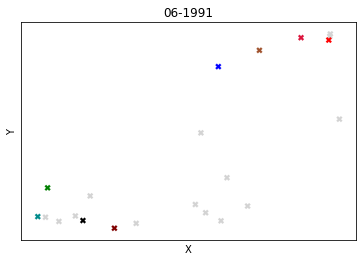

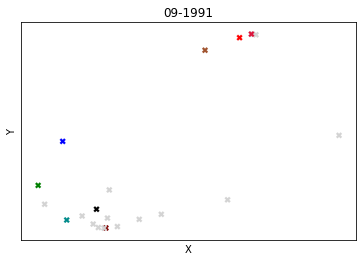

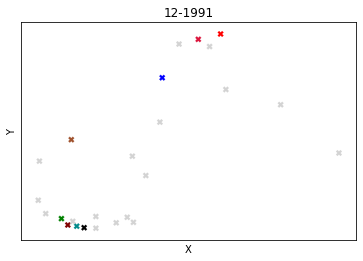

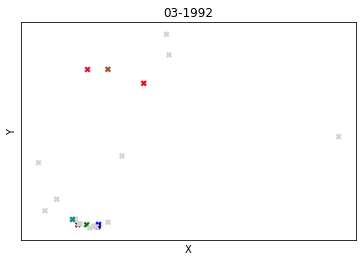

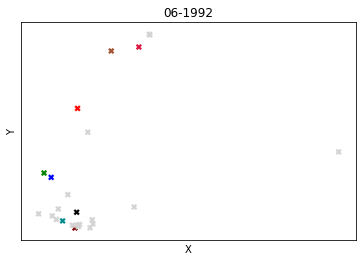

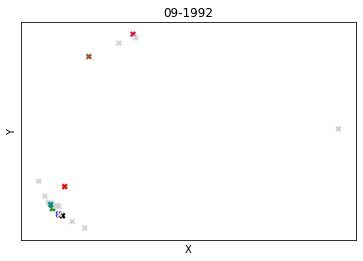

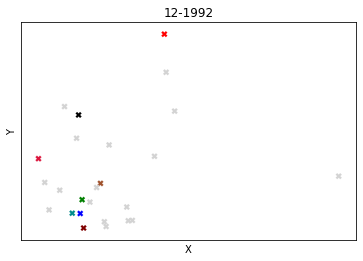

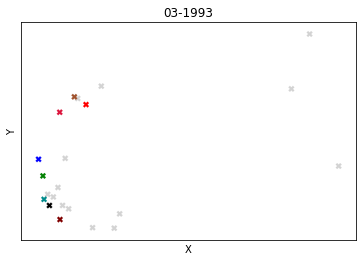

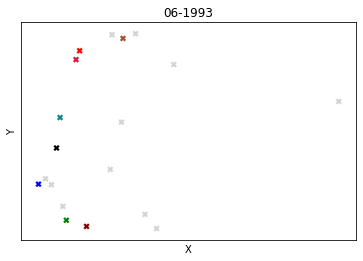

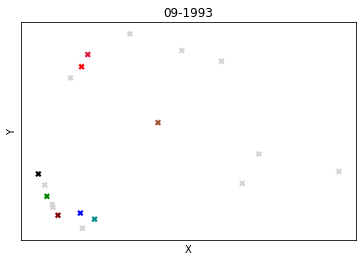

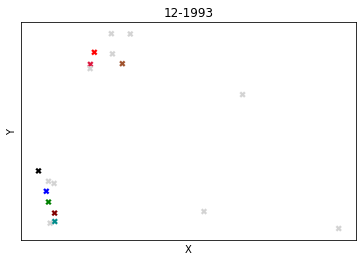

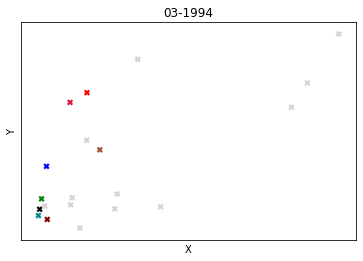

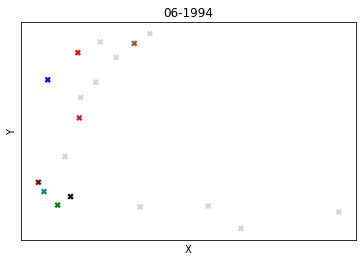

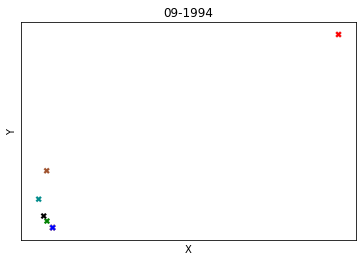

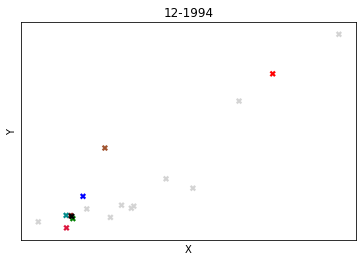

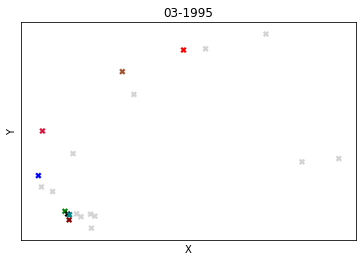

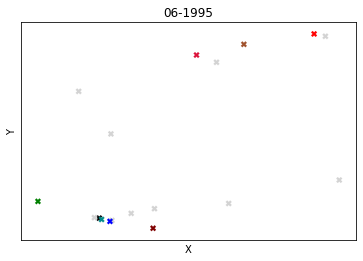

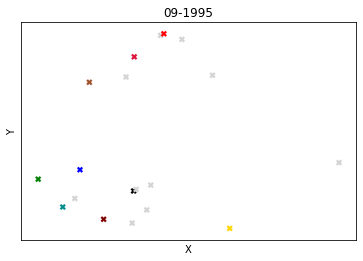

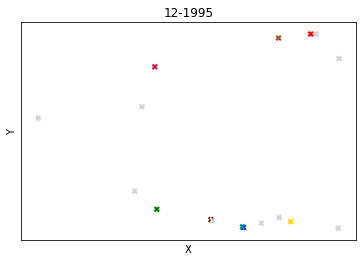

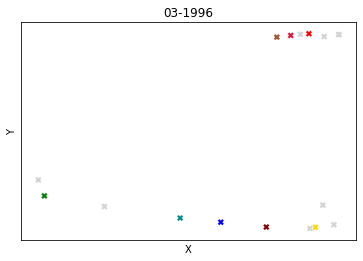

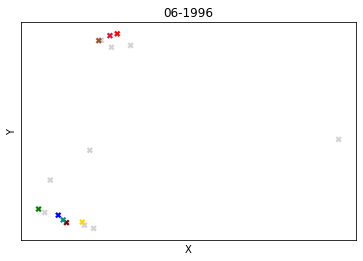

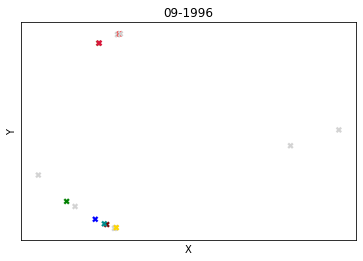

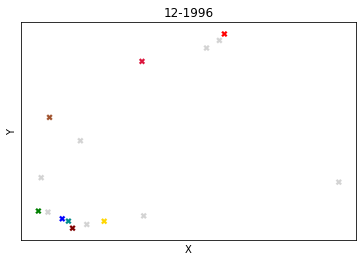

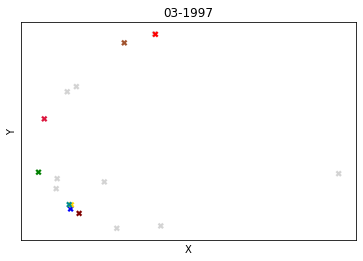

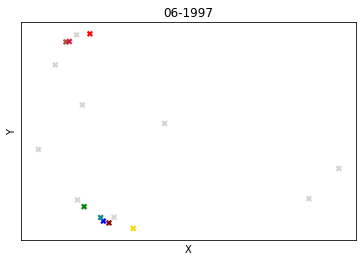

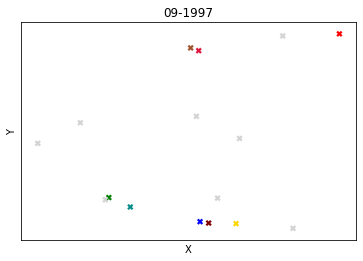

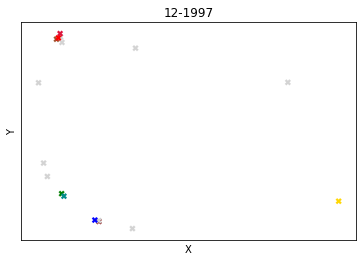

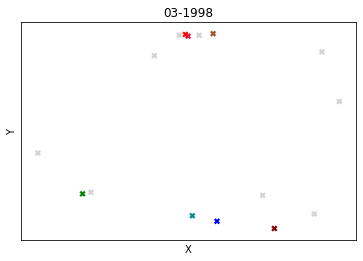

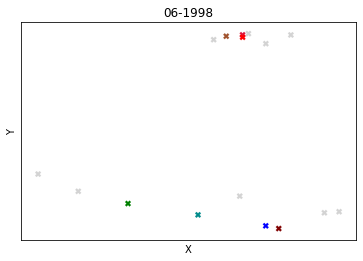

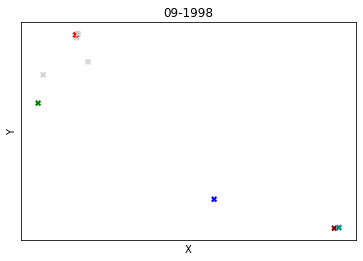

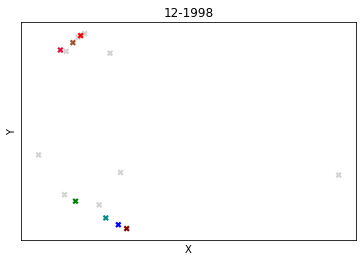

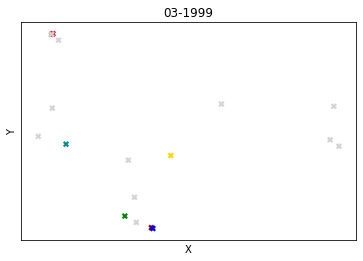

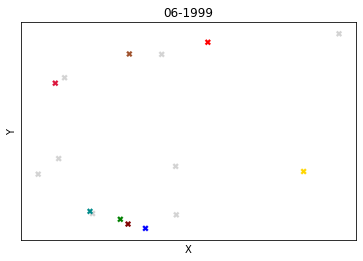

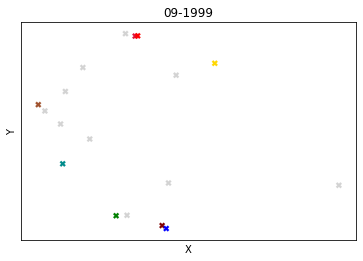

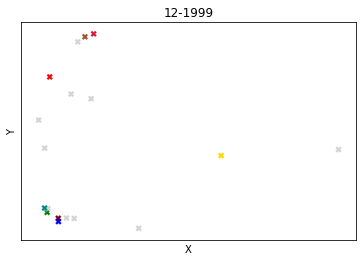

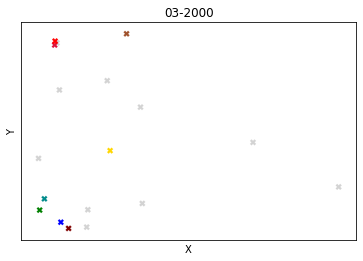

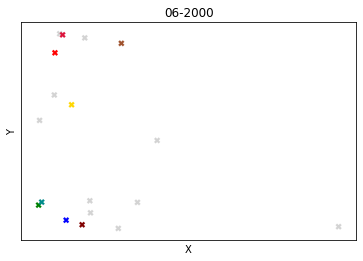

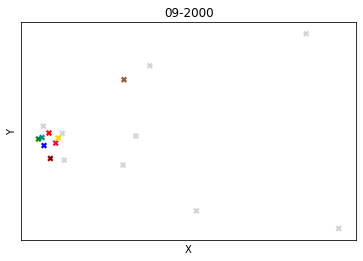

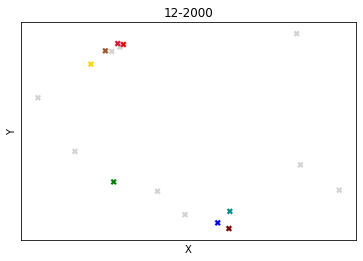

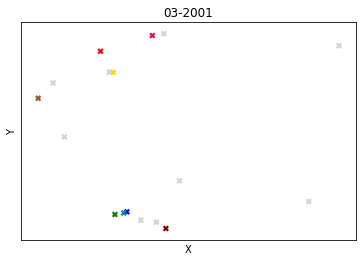

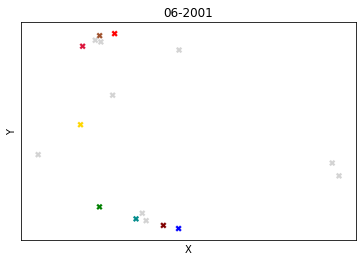

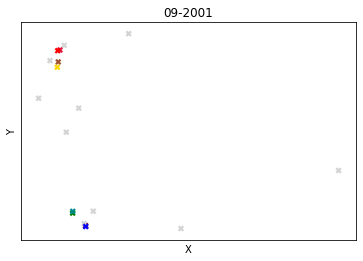

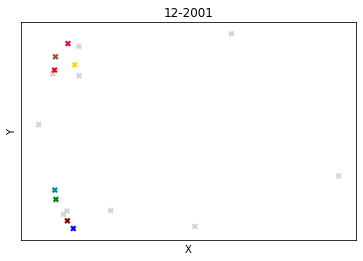

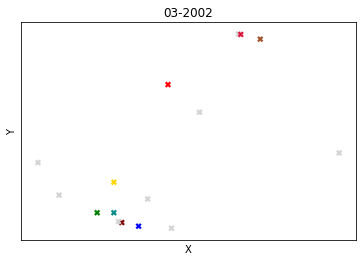

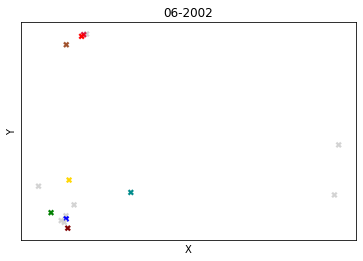

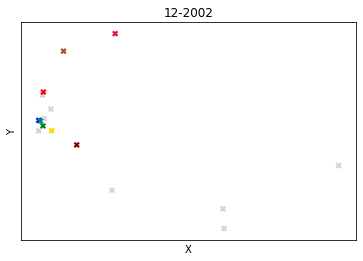

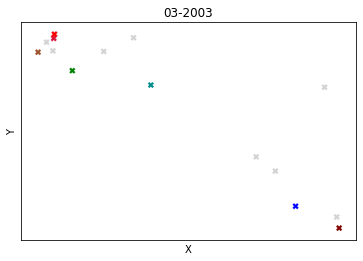

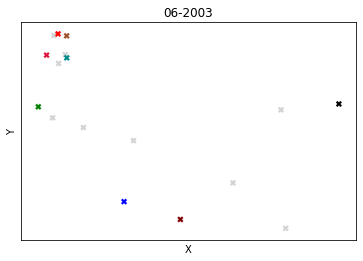

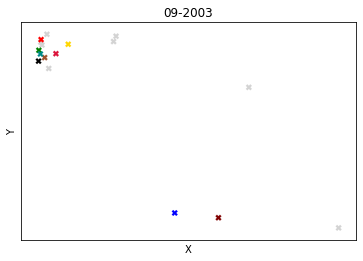

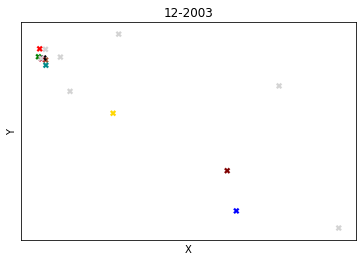

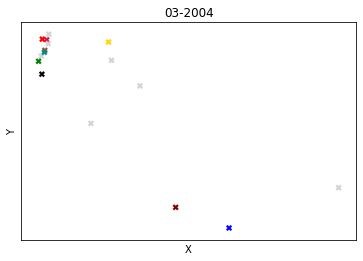

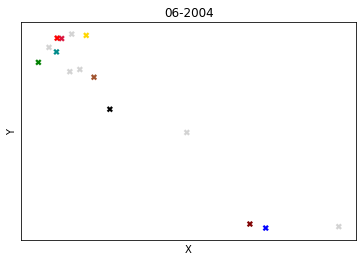

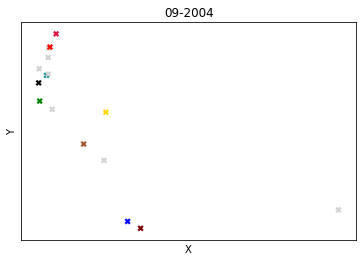

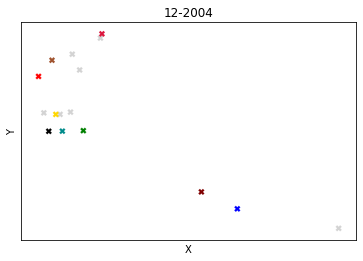

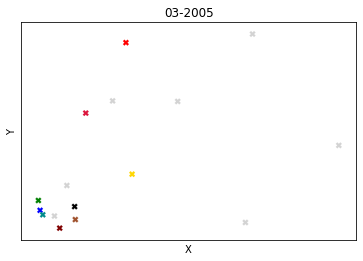

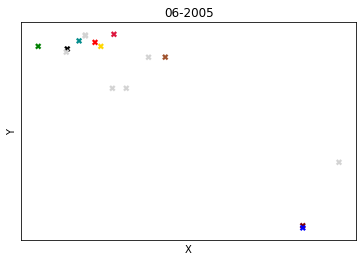

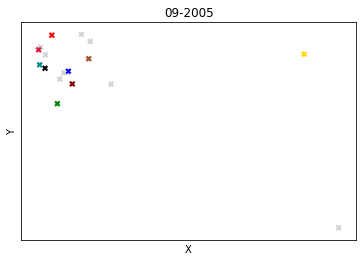

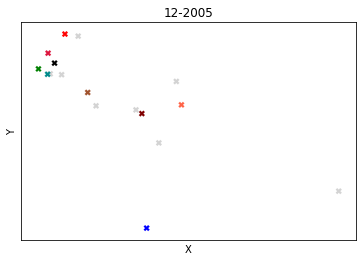

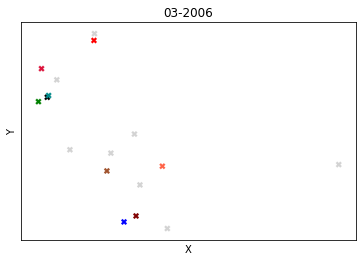

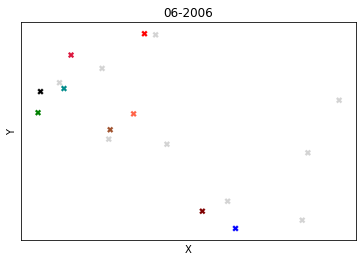

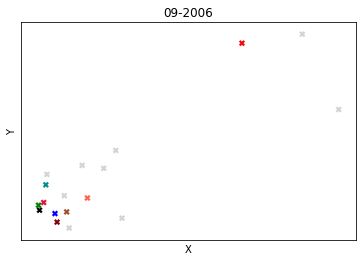

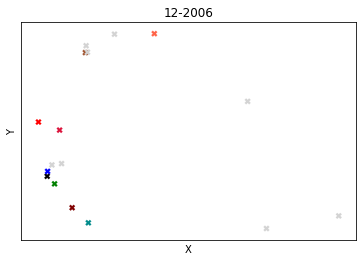

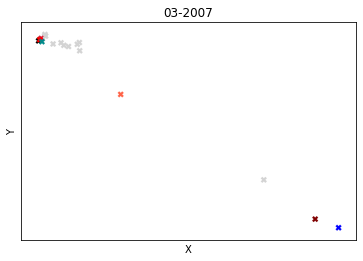

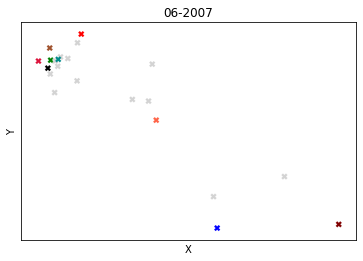

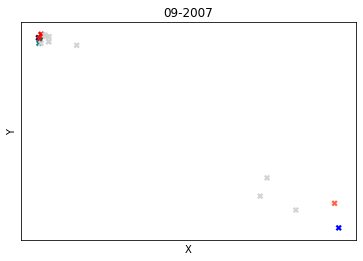

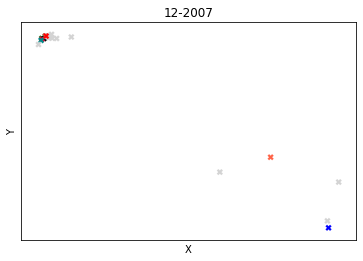

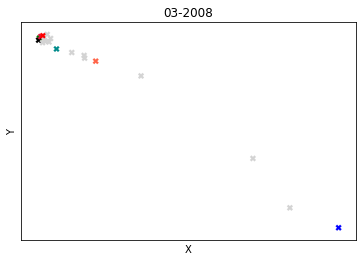

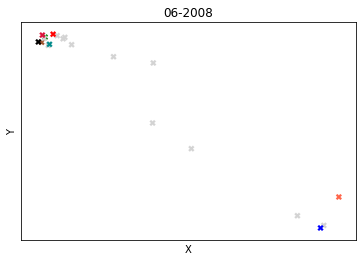

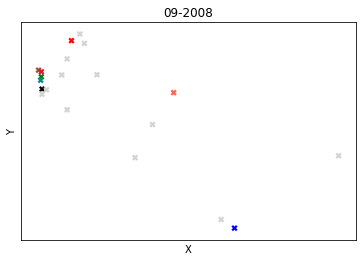

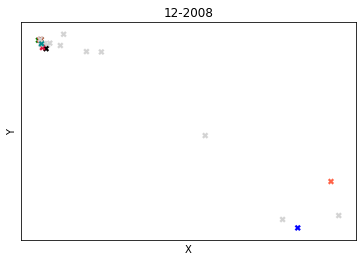

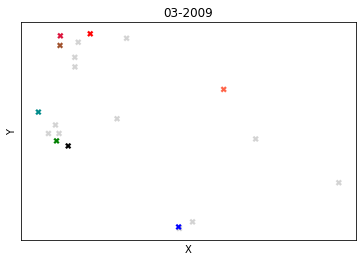

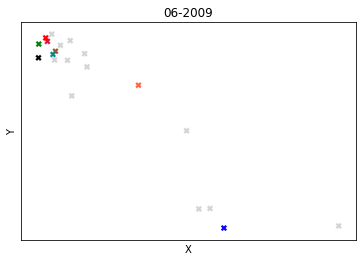

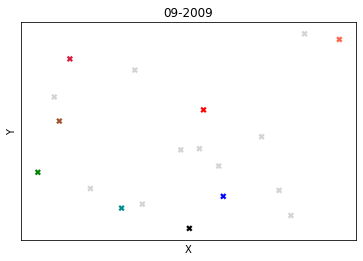

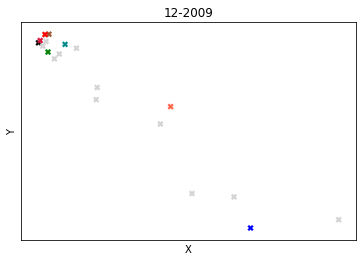

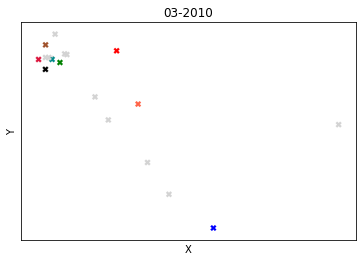

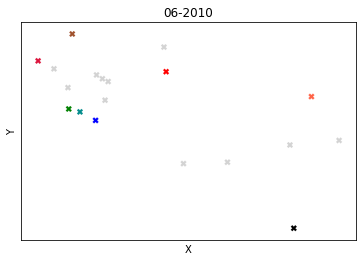

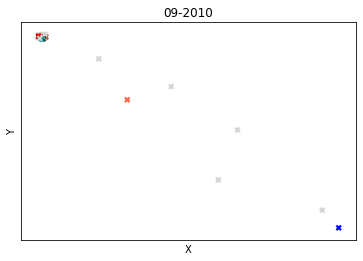

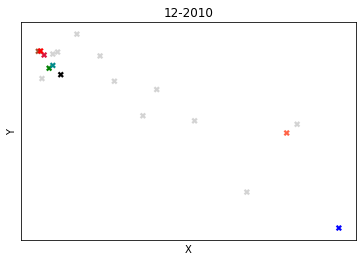

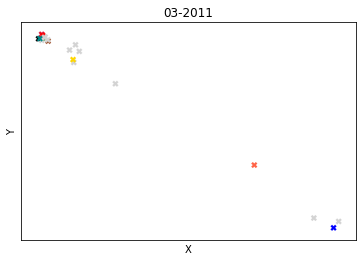

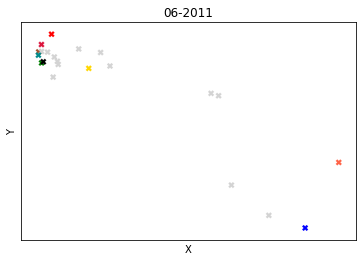

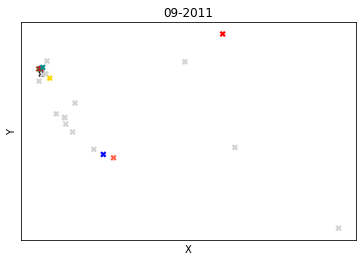

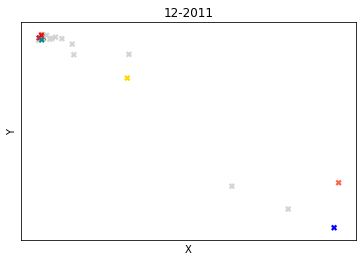

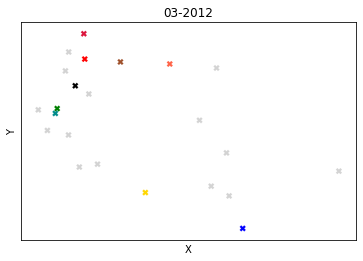

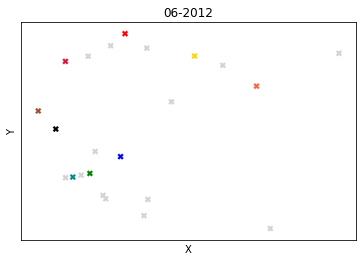

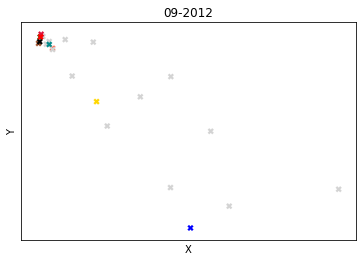

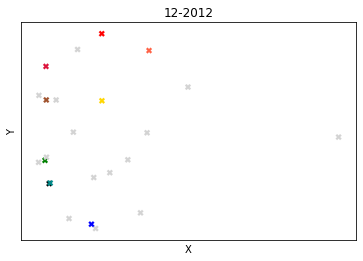

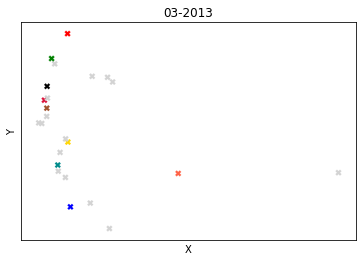

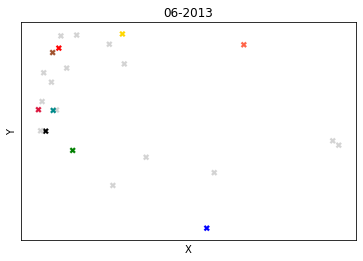

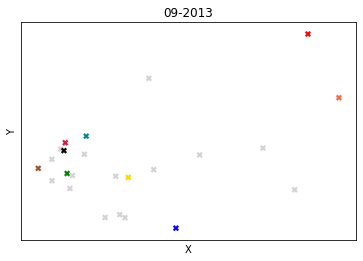

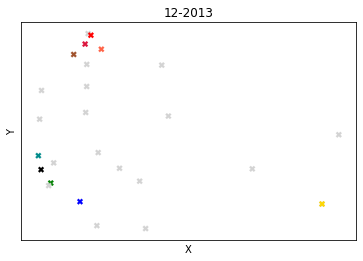

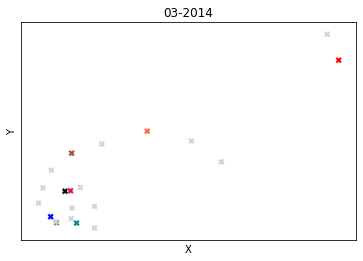

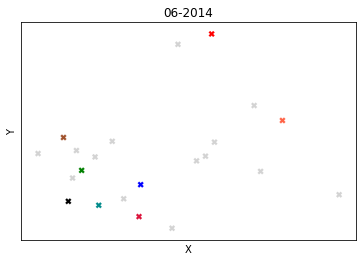

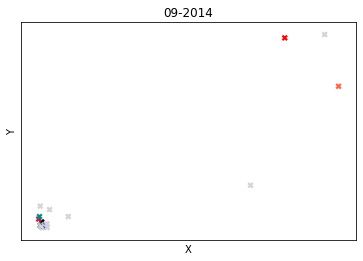

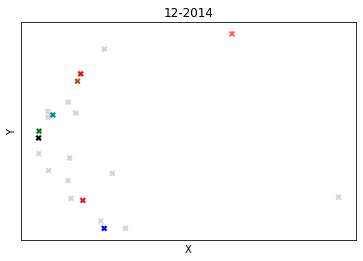

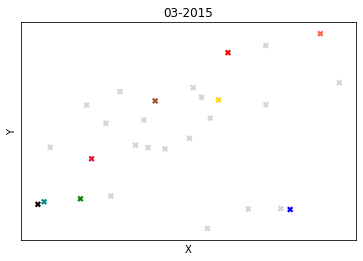

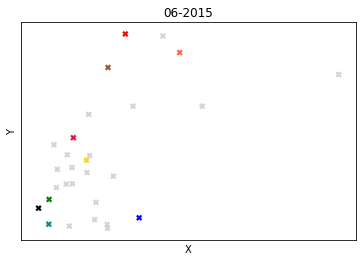

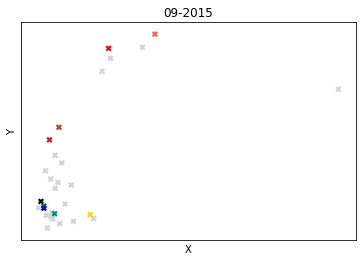

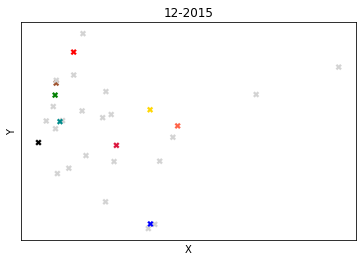

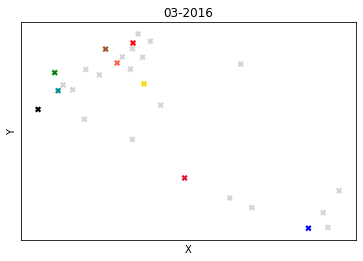

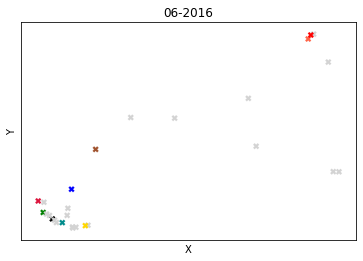

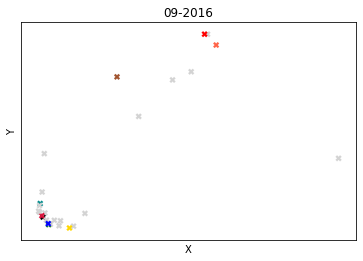

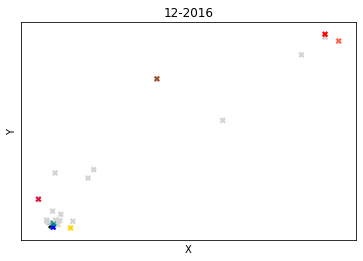

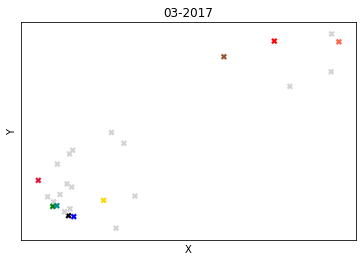

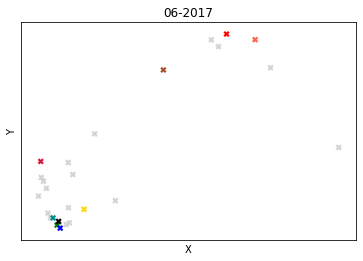

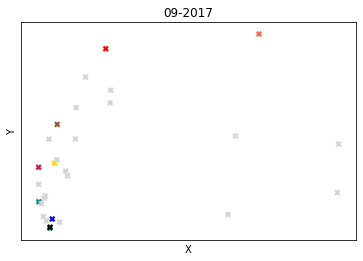

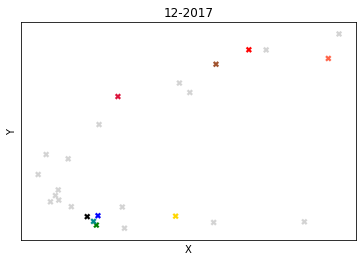

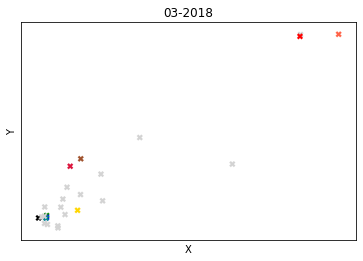

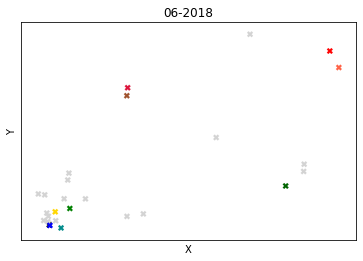

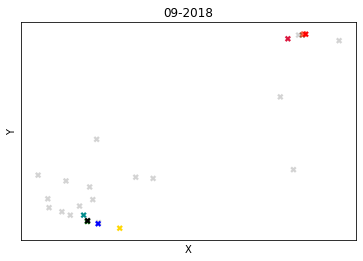

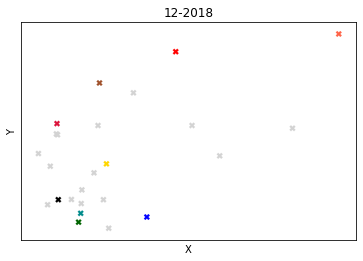

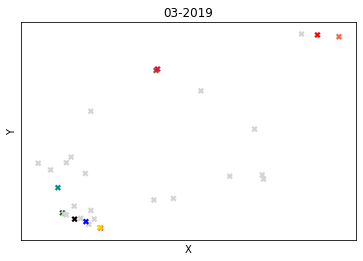

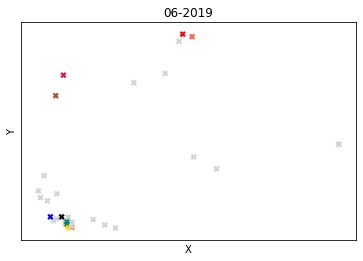

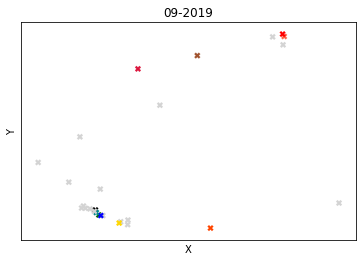

In [71]:
grouped_by = modelagem_partidos.groupby(pd.Grouper(freq='M') )
for i, (month_date, group) in tqdm_notebook(enumerate(grouped_by), total=len(grouped_by)):
    if group.shape[0] == 0:
        continue
    
    colors_to_use = [ get_color_static(p) for p in group['partido']  ]
    
    x = group['x']
    x = (x-x.mean())/x.std()
    x = x/max(abs(x))
    
    y = group['y']
    y = (y-y.mean())/y.std()
    y = y/max(abs(y))
    
    plt.scatter(x, y, marker='X', linewidths=0.1, c=colors_to_use)#, main=month_date.strftime('%m-%Y'), xticks=[], yticks=[])
    plt.title(month_date.strftime('%m-%Y'))
    plt.xlabel('X')
    plt.xticks([])
    plt.ylabel('Y')
    plt.yticks([])
    patch = [ mpatches.Patch(color=c, label=p) for p,c in colors_static.items() ] 
    #plt.legend(handles=patch, bbox_to_anchor=(1, 1))
    #pplot = group.plot.scatter( x='x', y='y', c=colors_to_use, title=month_date.strftime('%m-%Y'), xticks=[], yticks=[] )
    plt.savefig("figures/partidos/figure_%03d.png" % i)
    plt.show()

In [56]:
modelagem_deputado = modelagem[modelagem['tipo'] == 'deputado']
modelagem_deputado.head()

x         y             nome partido      tipo
data                                                             
1991-06-01  0.002482 -0.134975   Adauto Pereira     PFL  deputado
1991-06-01 -0.088539 -0.191242    Adelaide Neri    PMDB  deputado
1991-06-01 -0.051334  0.301228  Adroaldo Streck    PSDB  deputado
1991-06-01 -0.068568 -0.336429    Adylson Motta     PDS  deputado
1991-06-01  0.000969  0.484394      Adão Pretto      PT  deputado

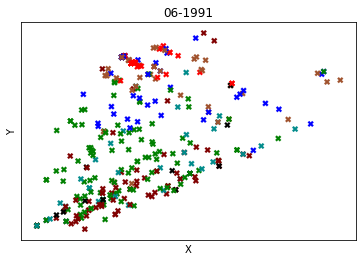

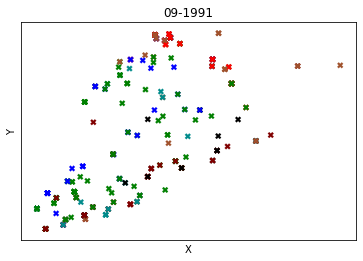

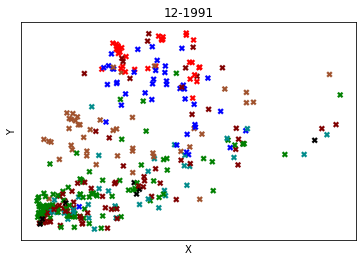

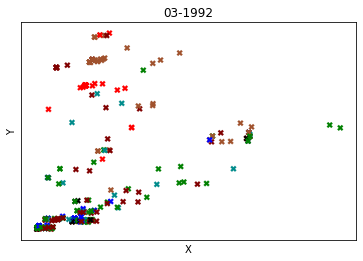

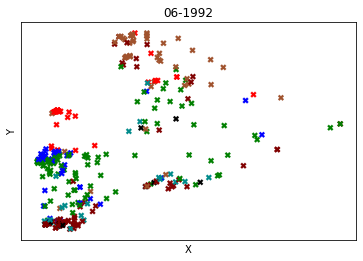

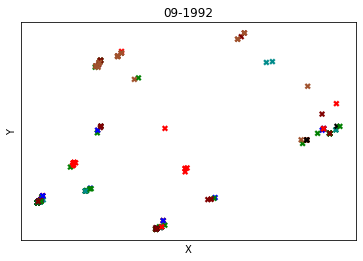

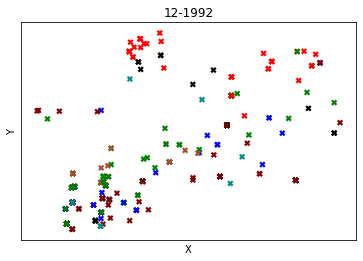

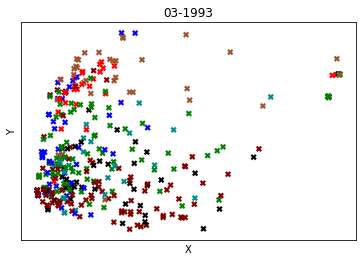

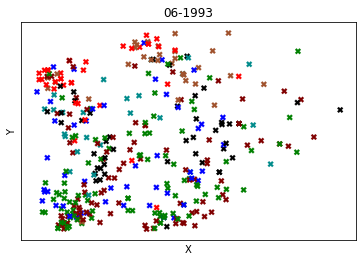

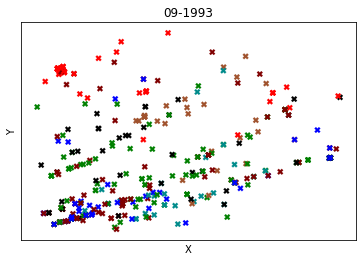

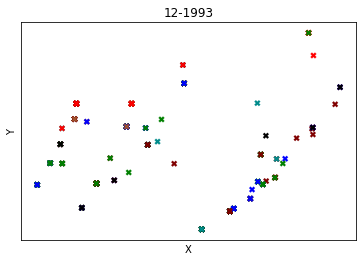

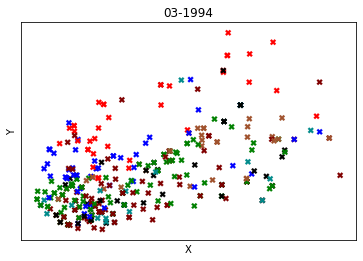

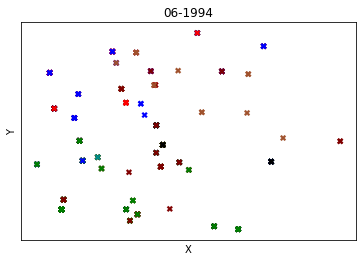

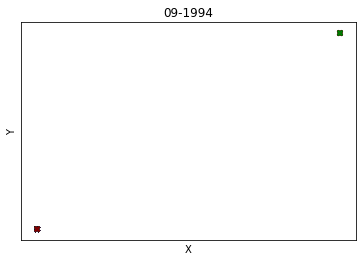

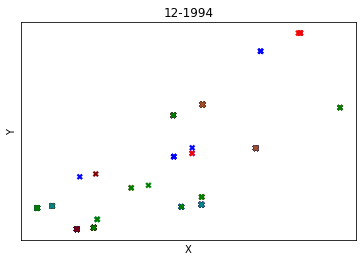

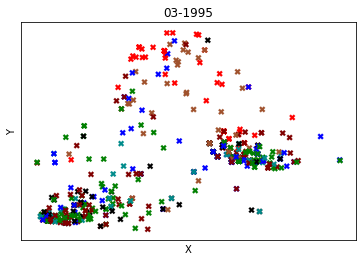

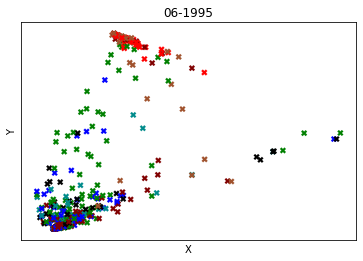

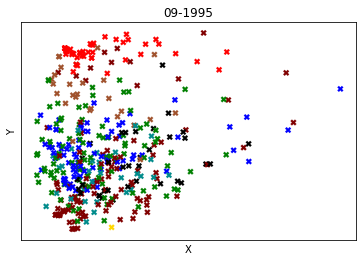

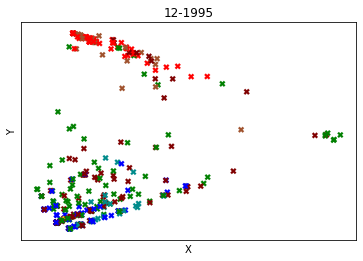

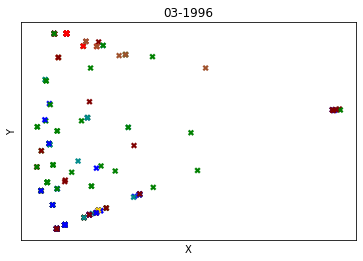

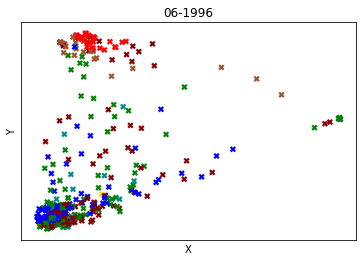

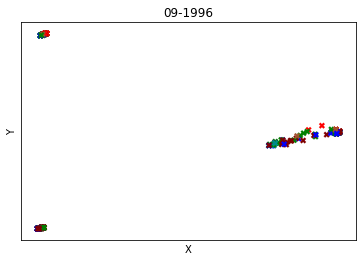

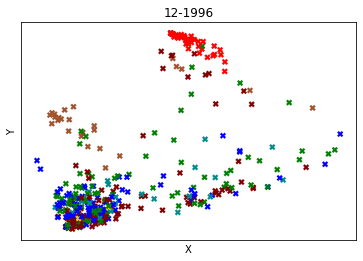

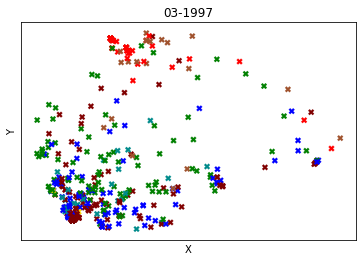

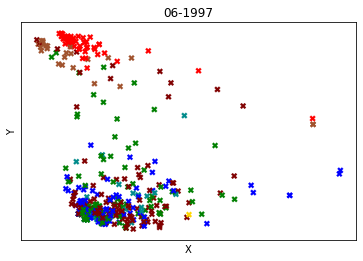

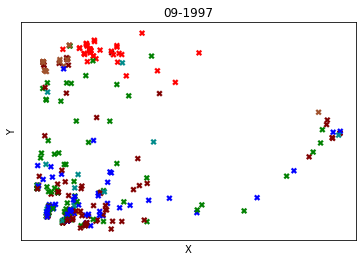

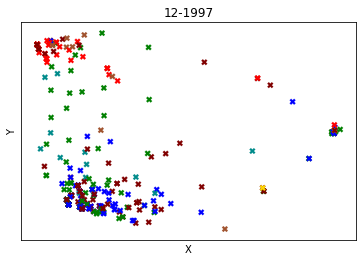

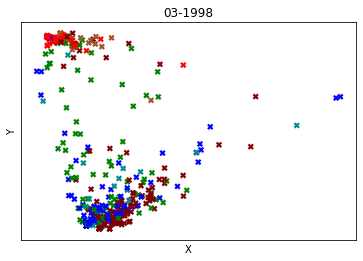

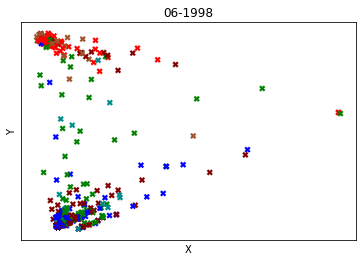

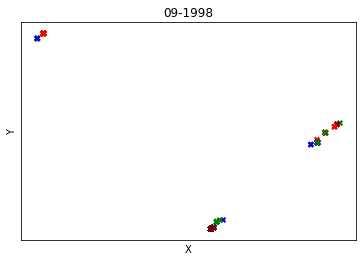

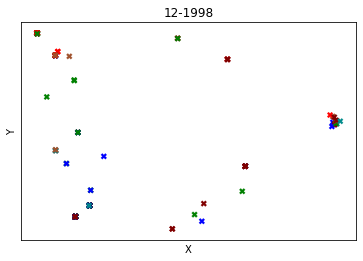

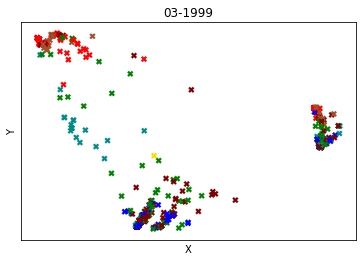

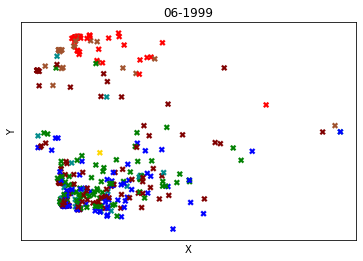

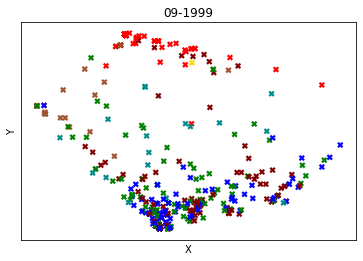

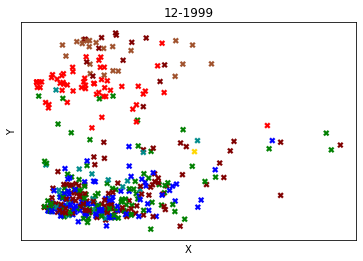

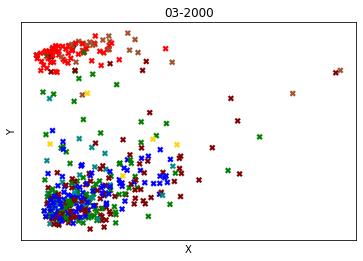

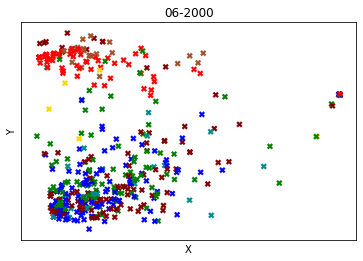

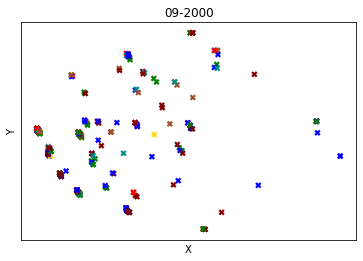

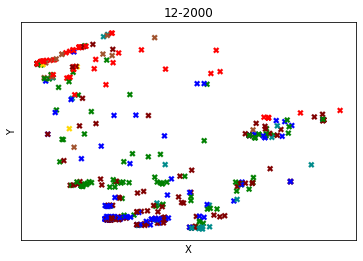

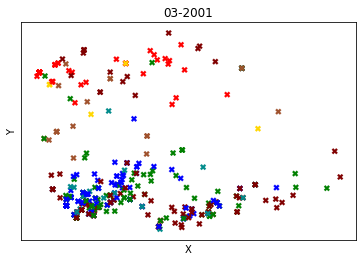

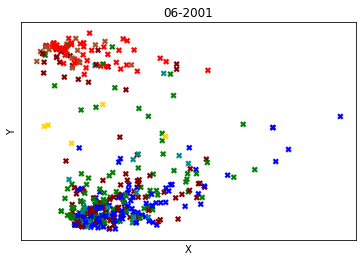

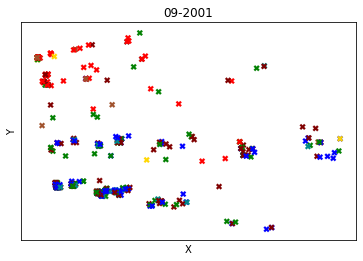

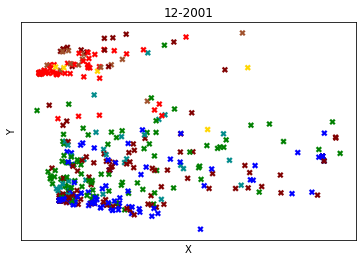

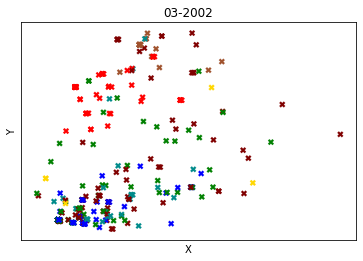

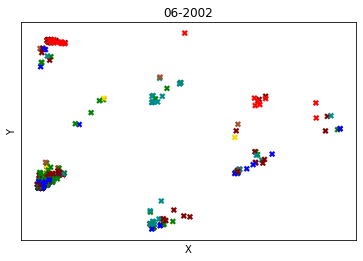

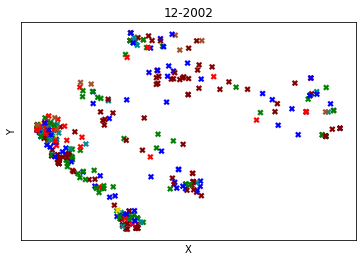

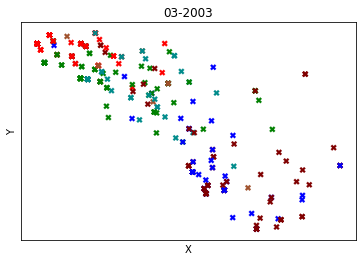

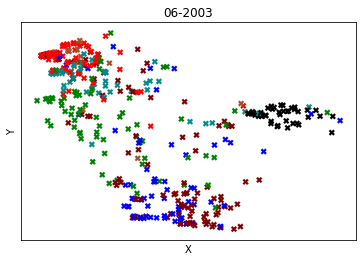

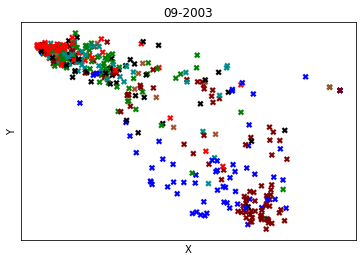

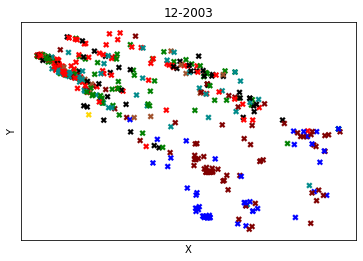

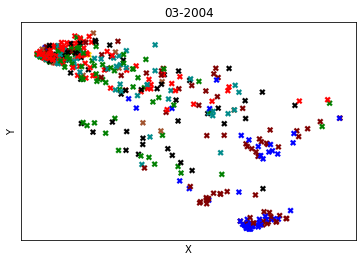

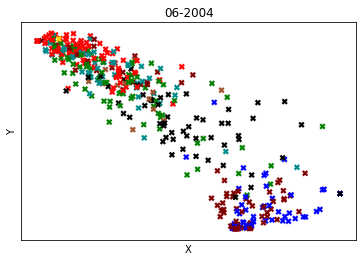

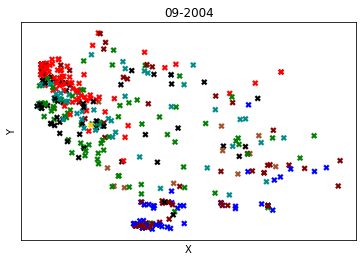

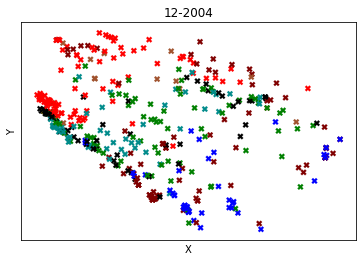

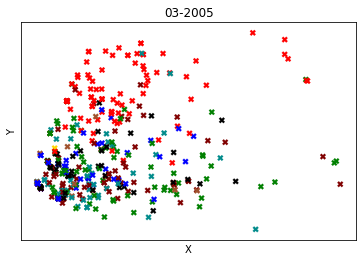

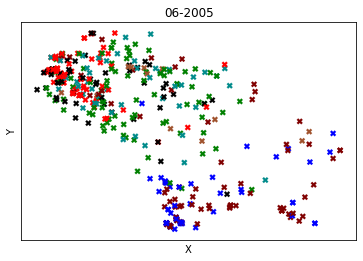

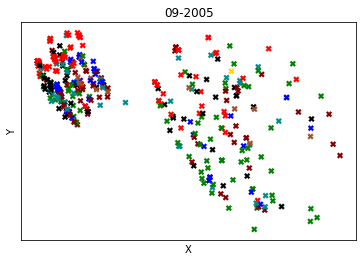

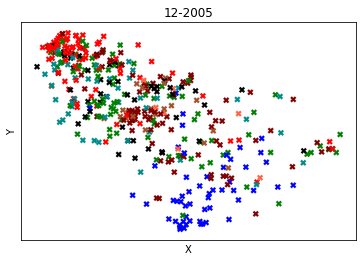

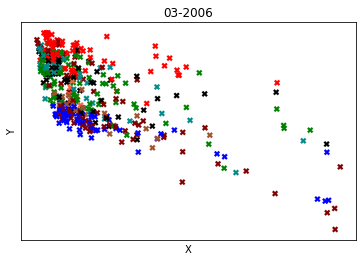

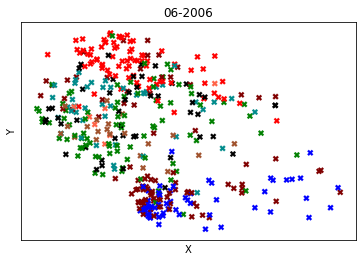

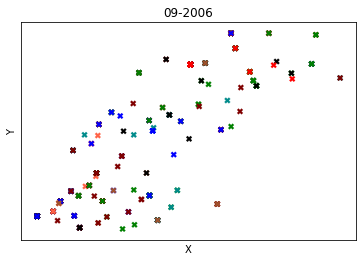

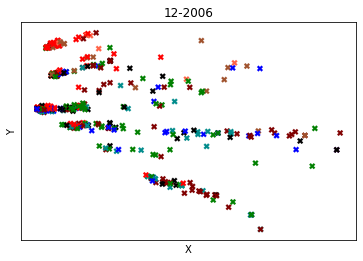

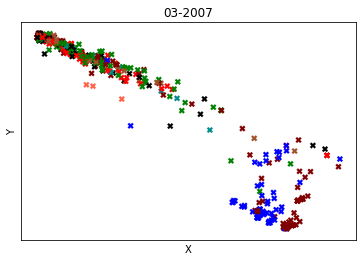

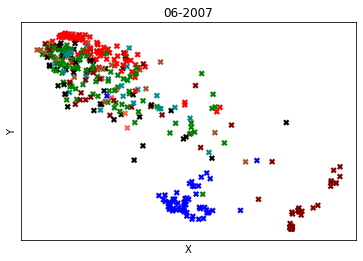

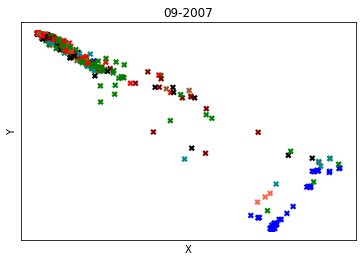

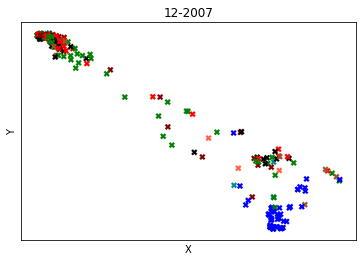

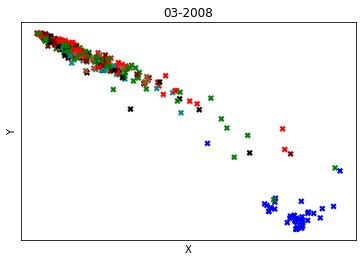

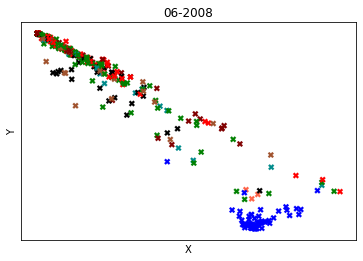

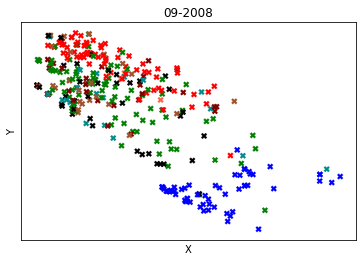

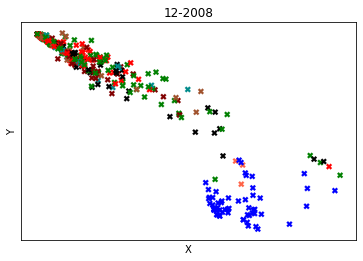

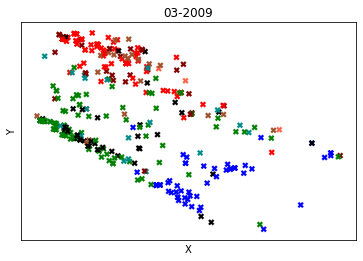

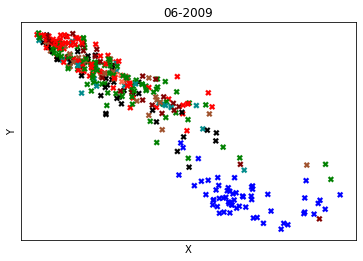

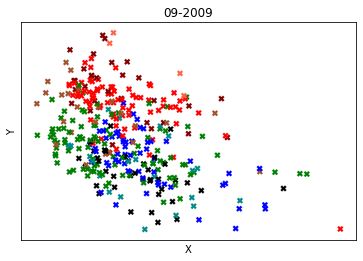

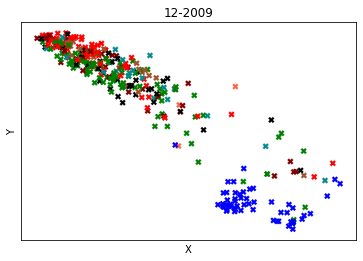

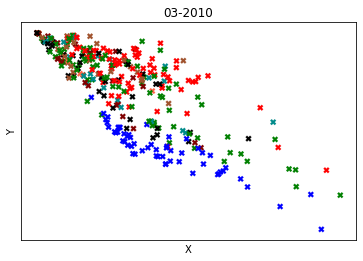

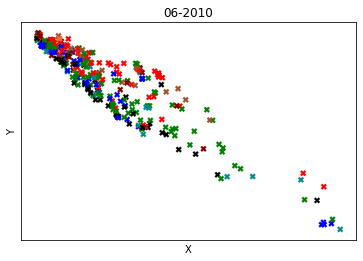

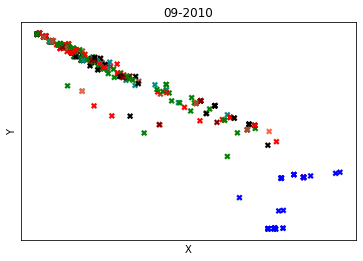

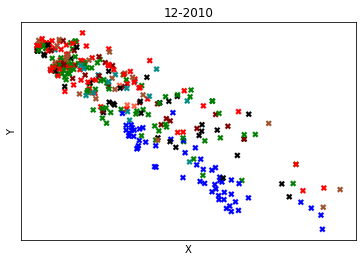

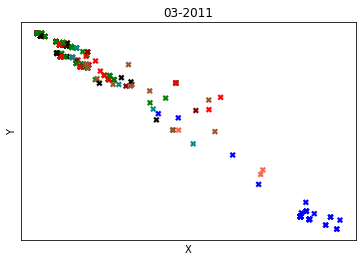

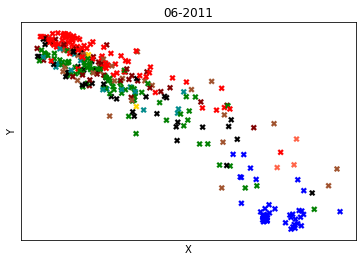

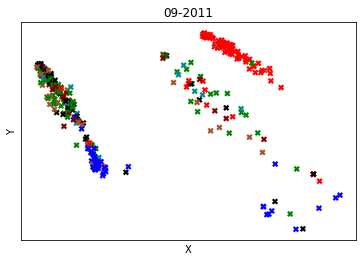

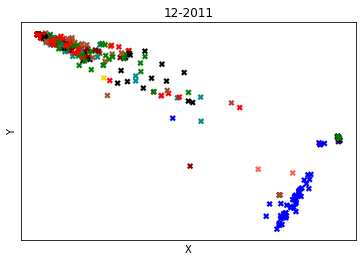

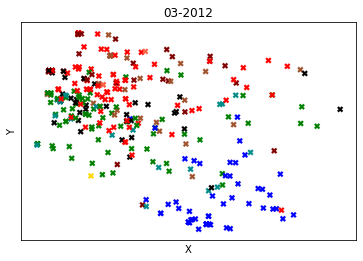

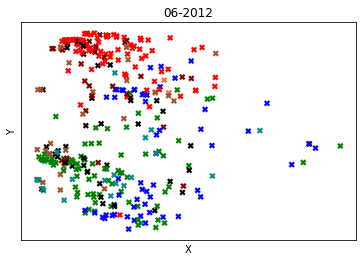

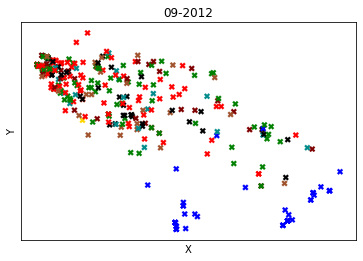

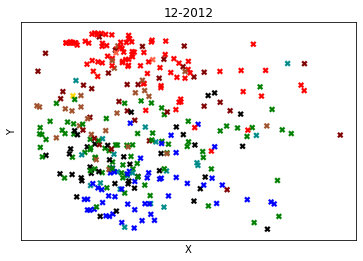

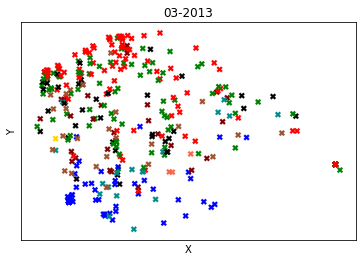

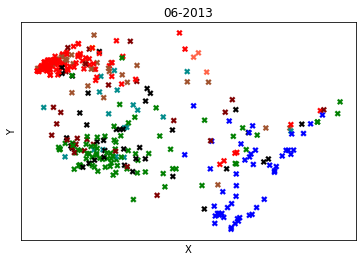

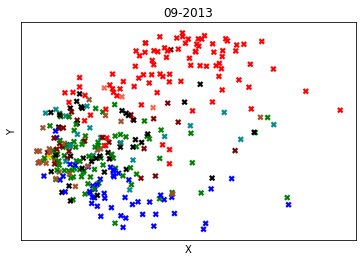

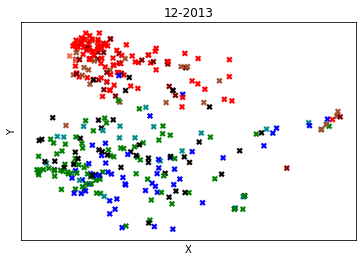

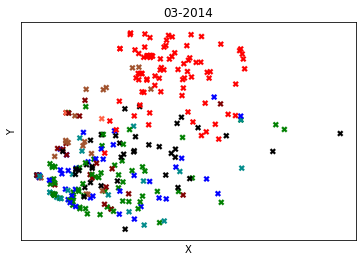

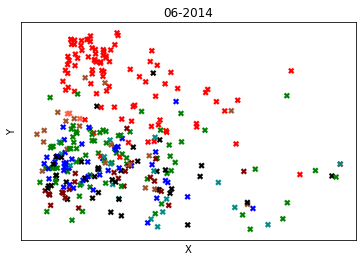

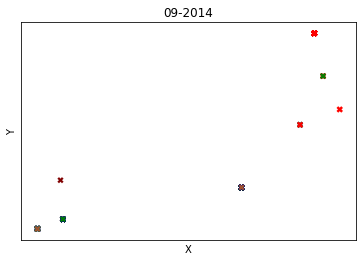

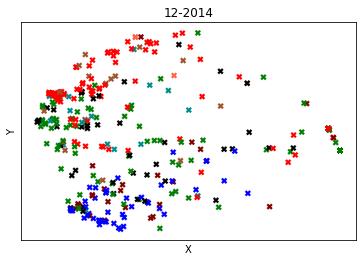

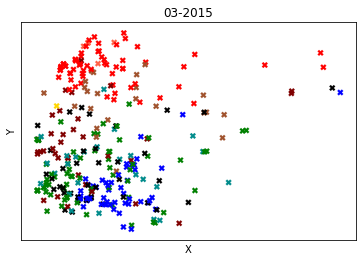

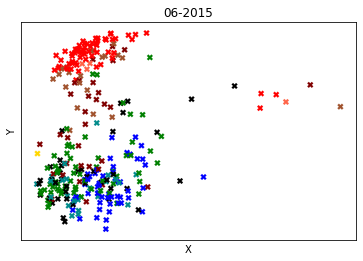

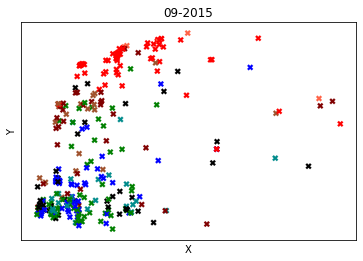

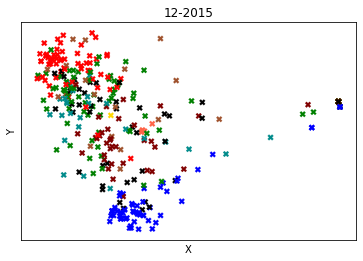

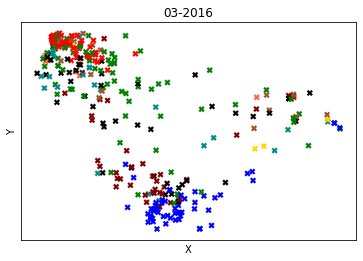

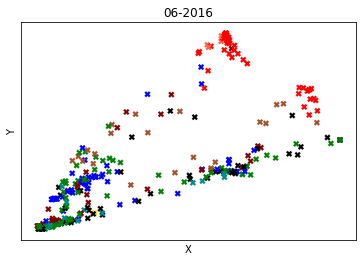

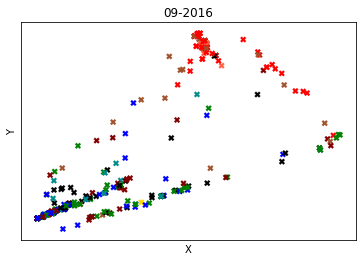

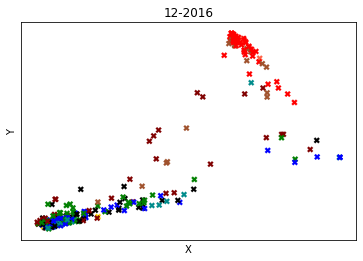

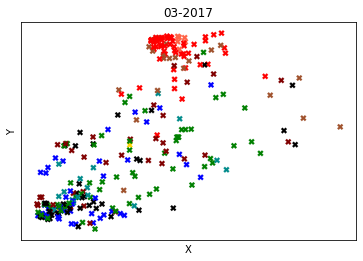

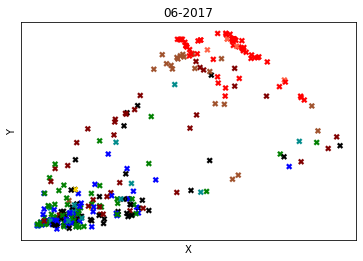

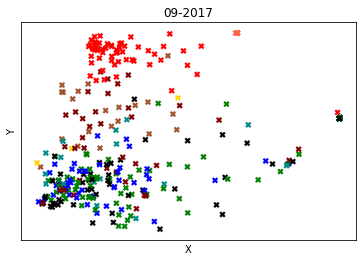

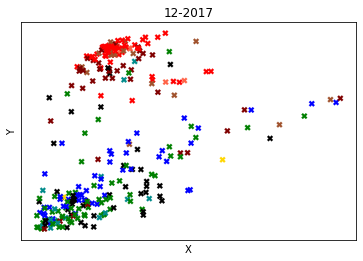

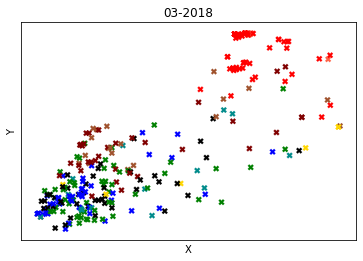

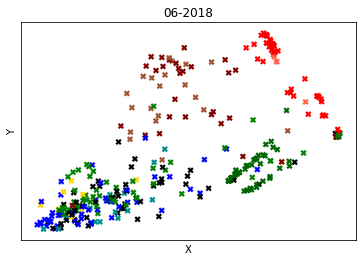

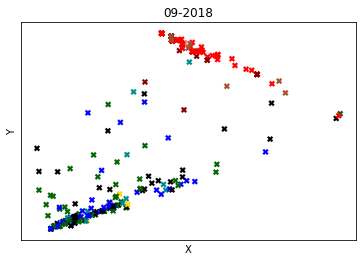

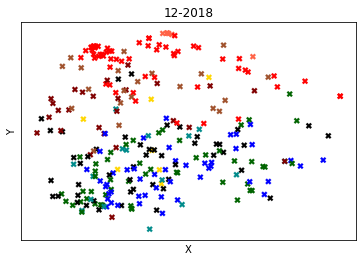

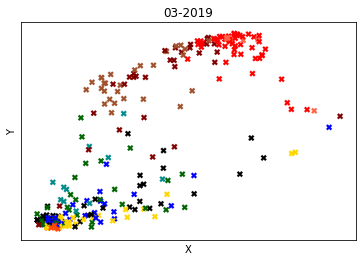

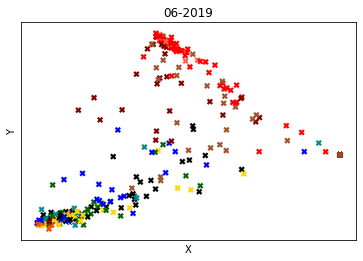

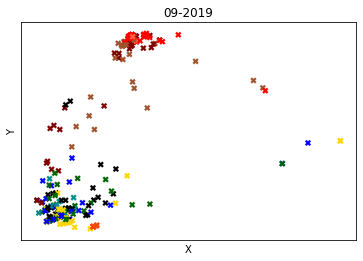

In [57]:
grouped_by = modelagem_deputado.groupby(pd.Grouper(freq='M') )
for i, (month_date, group) in tqdm_notebook(enumerate(grouped_by), total=len(grouped_by)):
    if group.shape[0] == 0:
        continue
    group = group[[p in colors_static for p in group['partido']]]
    colors_to_use = [ get_color_static(p) for p in group['partido']  ]
    x = (group['x']-group['x'].mean())/group['x'].std()
    y = (group['y']-group['y'].mean())/group['y'].std()
    plt.scatter(x, y, marker='X', linewidths=0.1, c=colors_to_use)#, main=month_date.strftime('%m-%Y'), xticks=[], yticks=[])
    plt.title(month_date.strftime('%m-%Y'))
    plt.xlabel('X')
    plt.xticks([])
    plt.ylabel('Y')
    plt.yticks([])
    patch = [ mpatches.Patch(color=c, label=p) for p,c in colors_static.items() ] 
    #plt.legend(handles=patch, bbox_to_anchor=(1, 1))
    #group.plot.scatter( x='x', y='y', c=colors_to_use, title=month_date.strftime('%m-%Y'), xticks=[], yticks=[]  )
    plt.savefig("figures/deputados/figure_%03d.png" % i)
    plt.show()
    #break

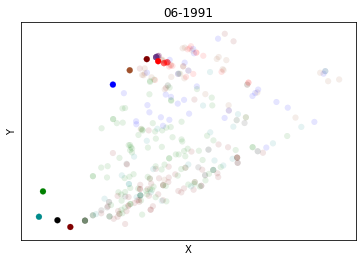

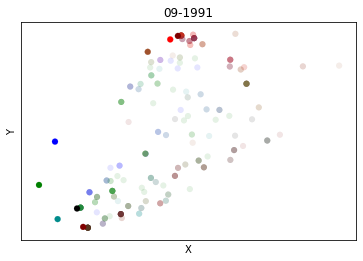

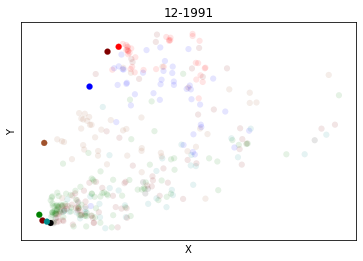

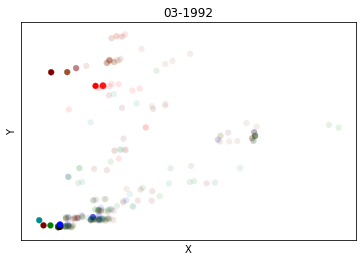

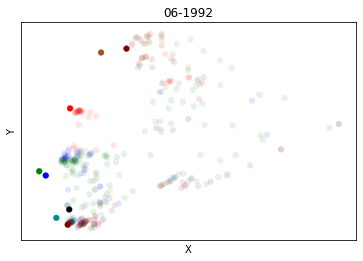

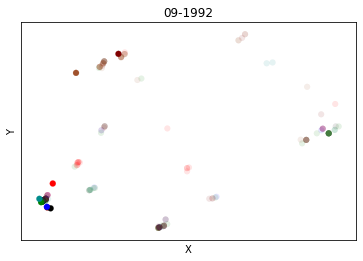

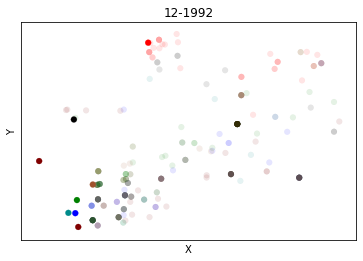

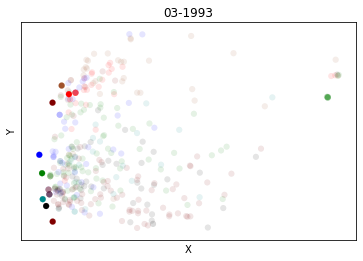

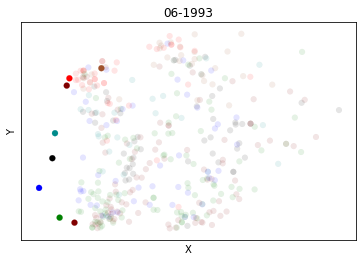

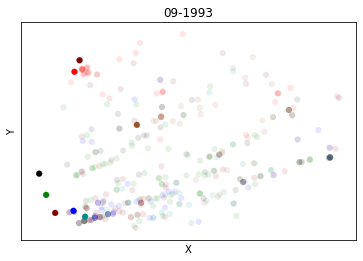

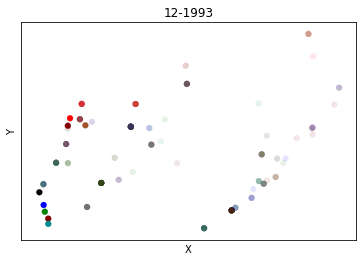

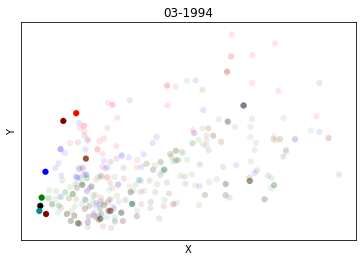

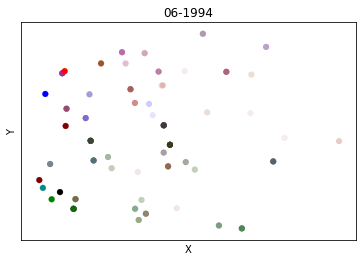

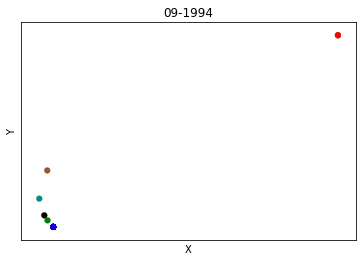

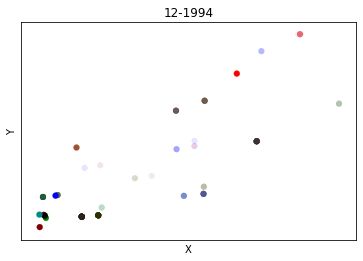

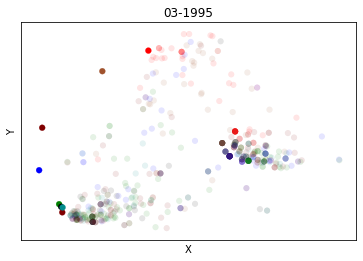

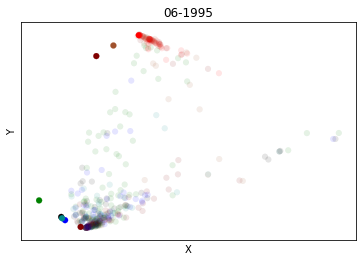

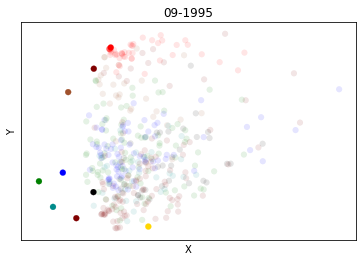

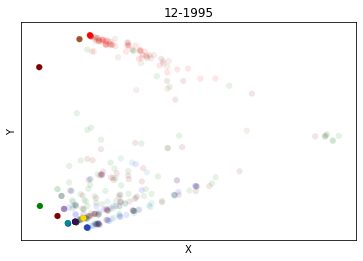

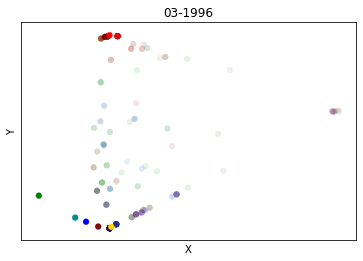

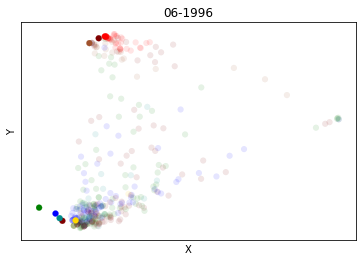

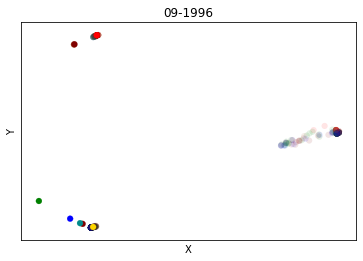

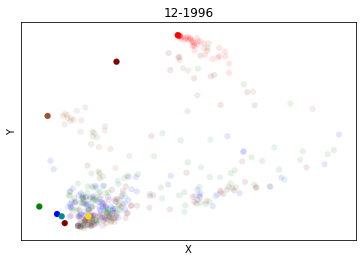

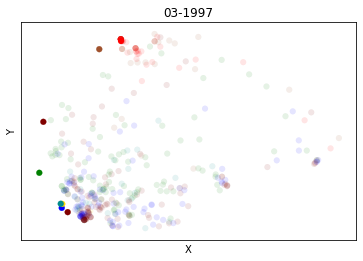

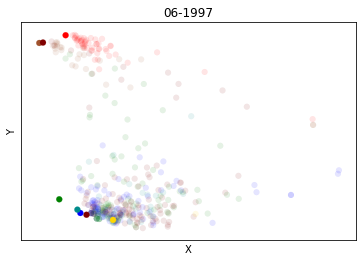

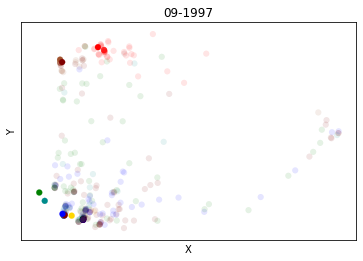

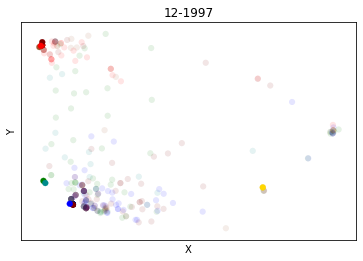

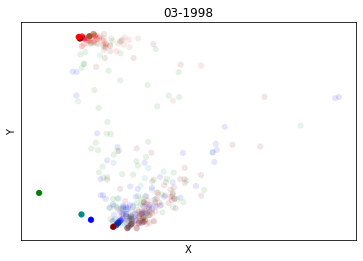

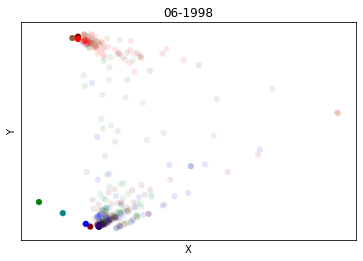

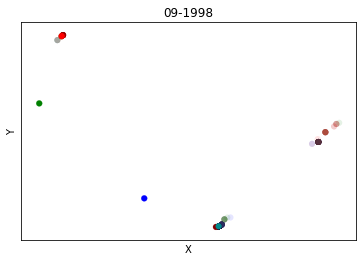

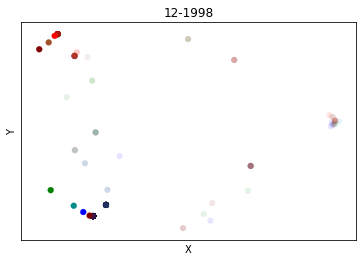

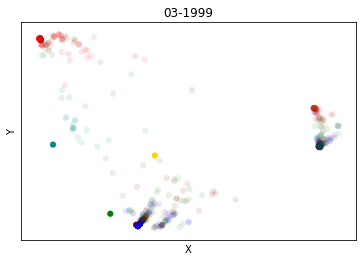

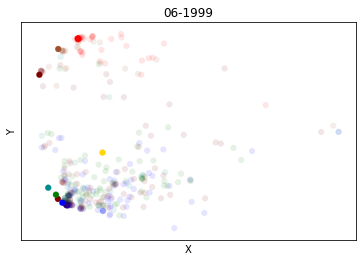

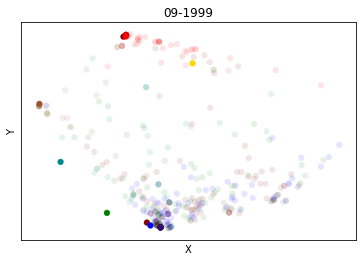

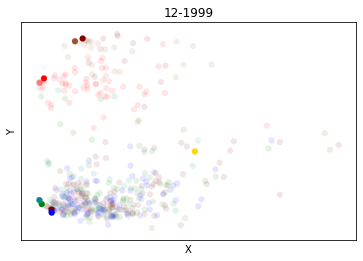

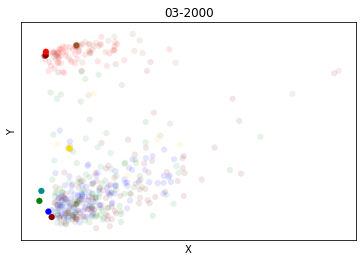

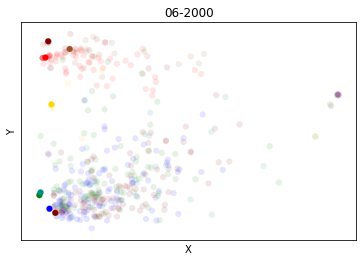

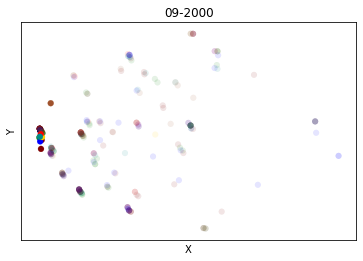

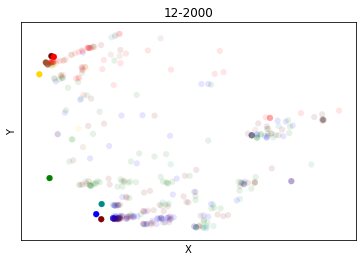

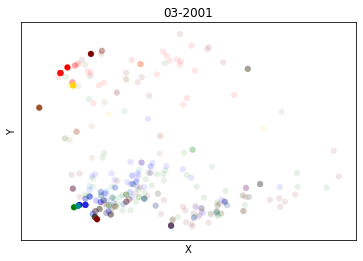

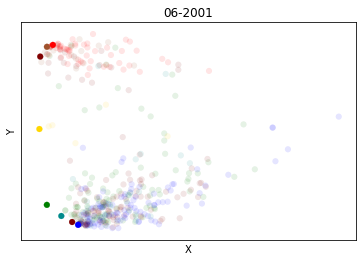

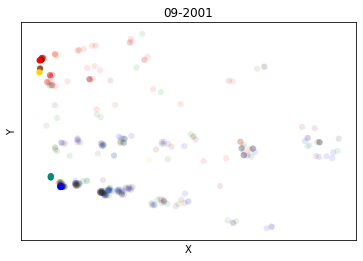

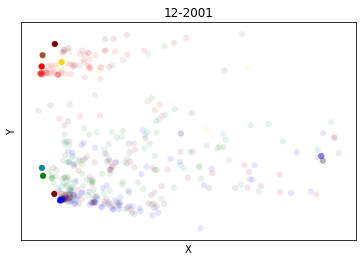

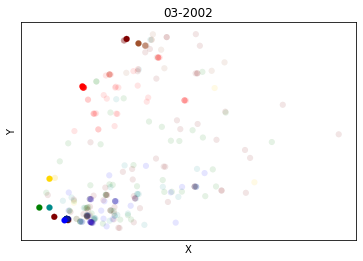

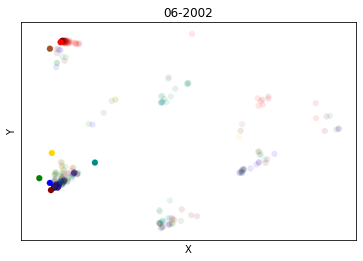

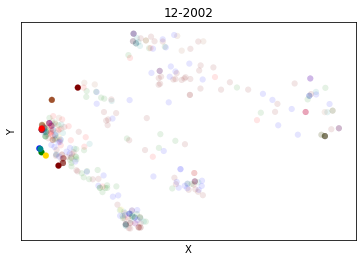

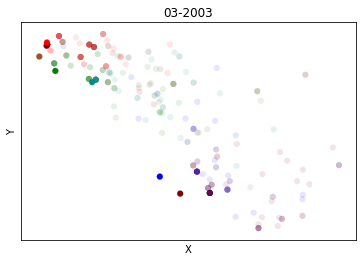

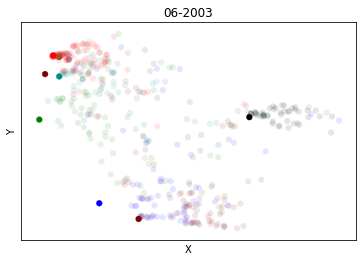

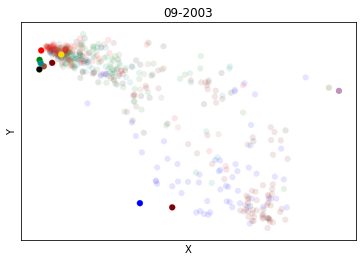

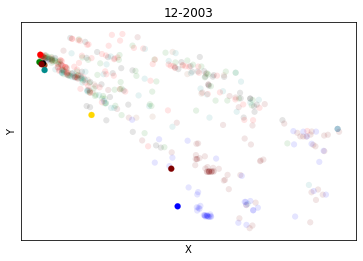

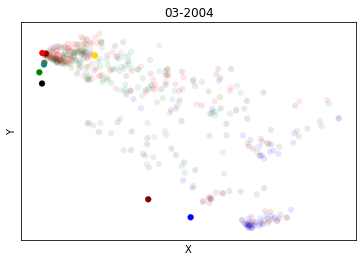

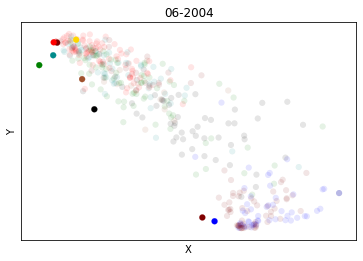

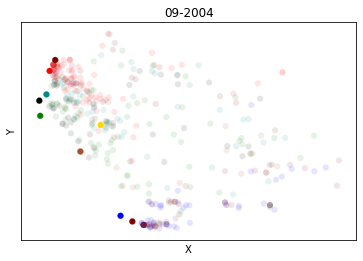

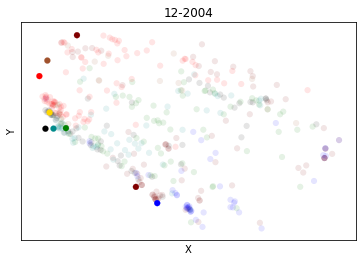

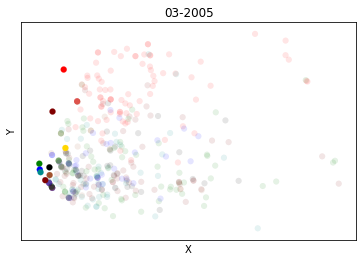

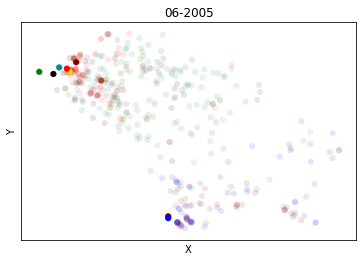

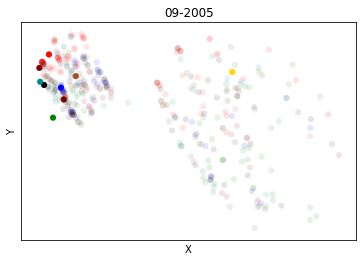

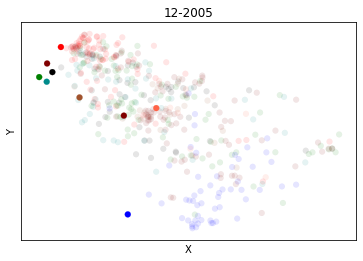

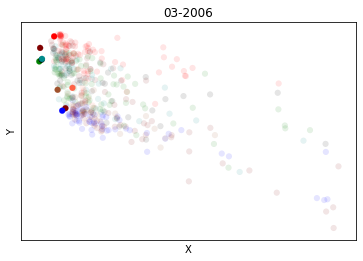

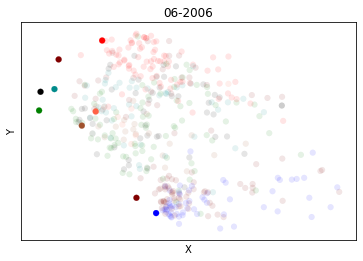

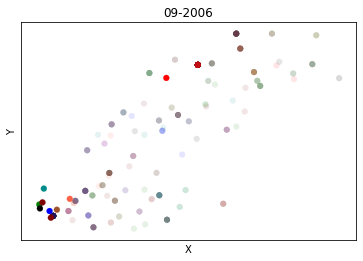

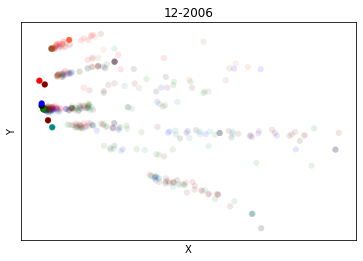

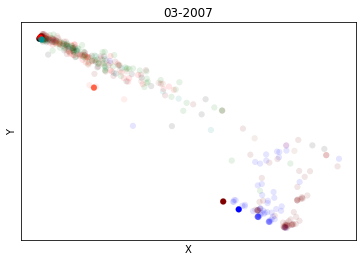

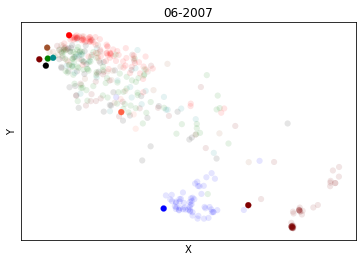

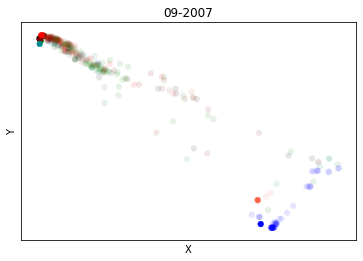

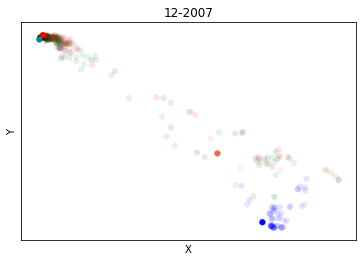

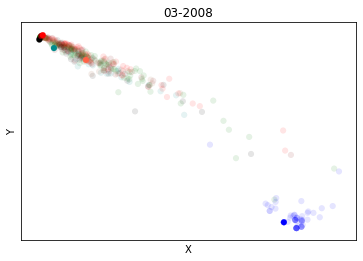

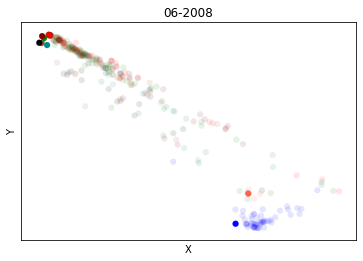

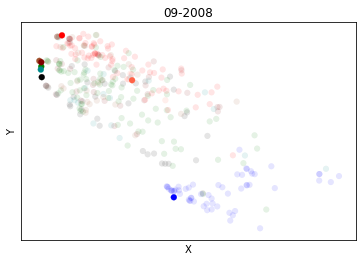

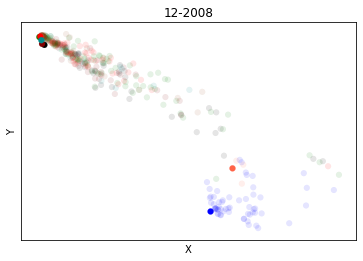

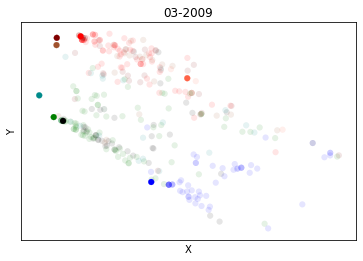

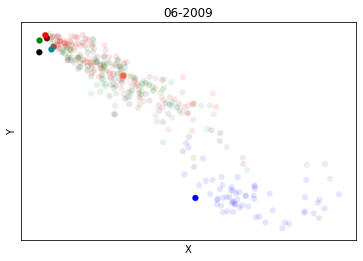

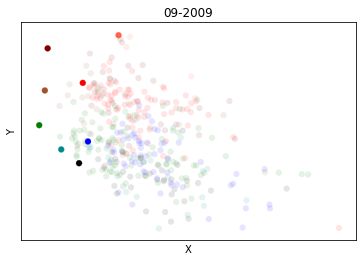

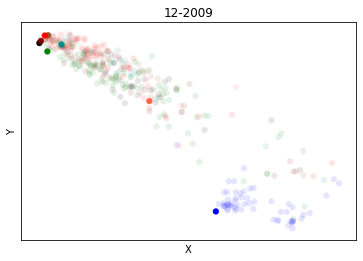

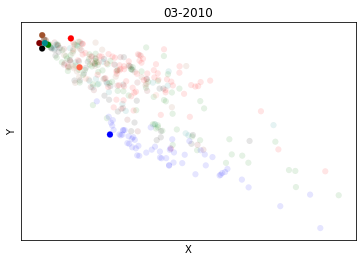

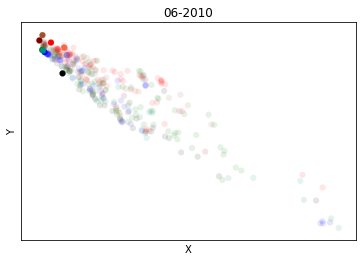

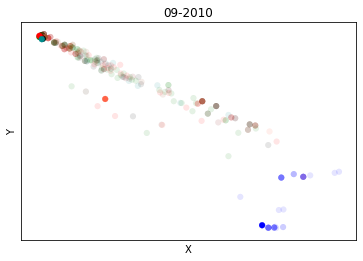

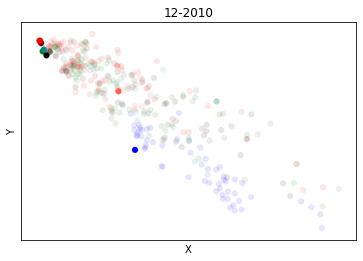

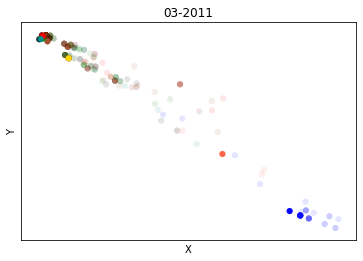

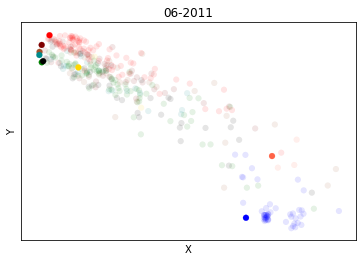

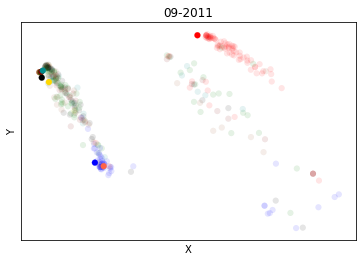

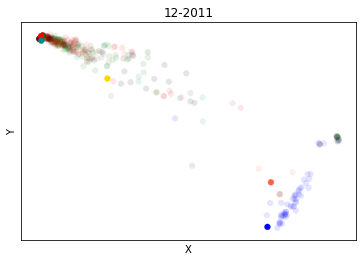

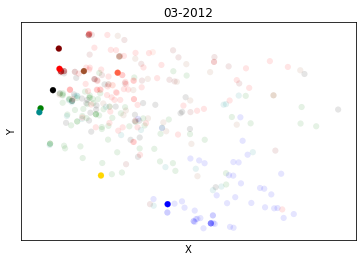

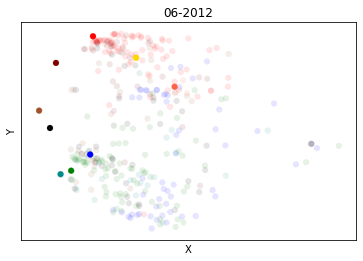

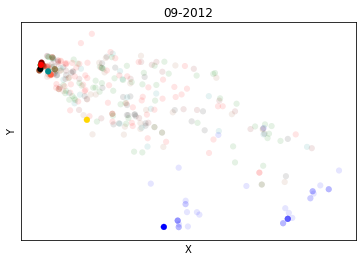

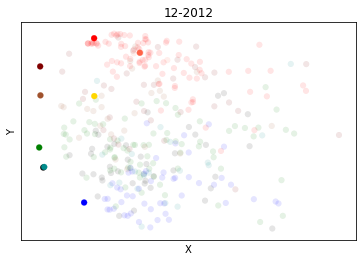

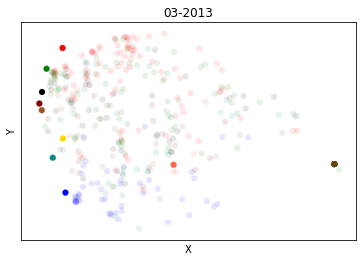

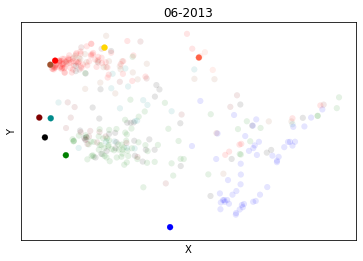

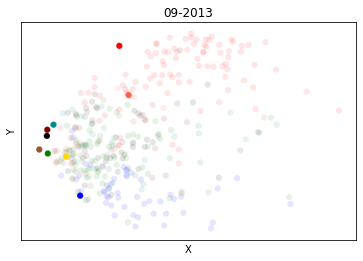

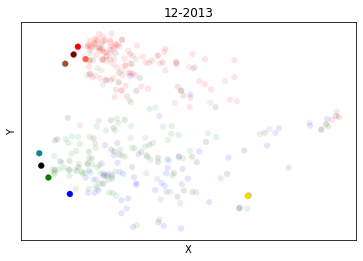

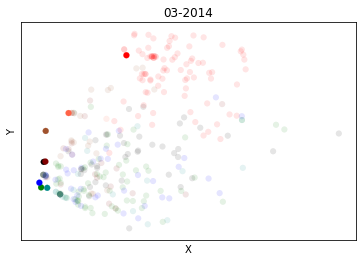

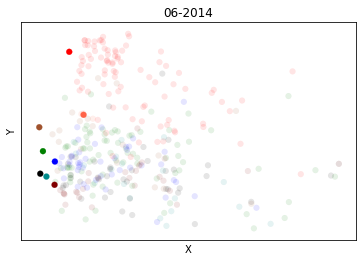

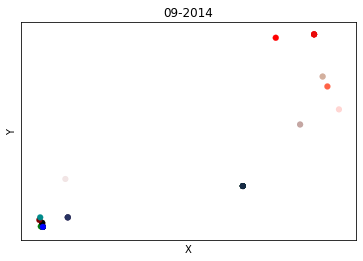

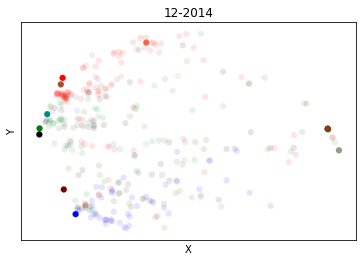

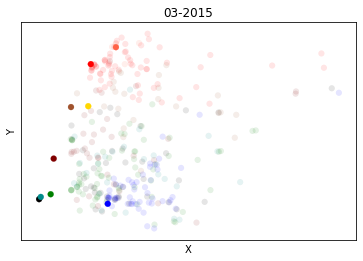

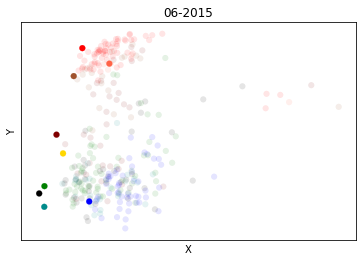

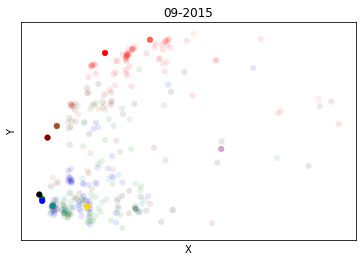

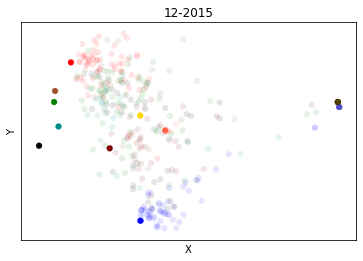

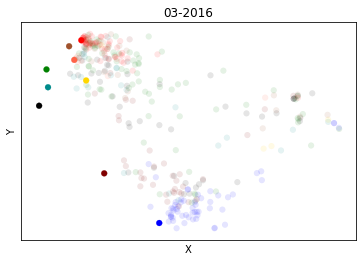

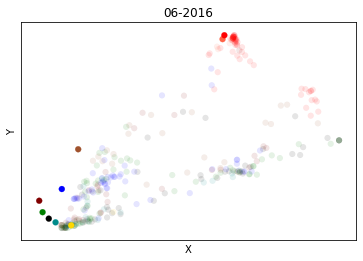

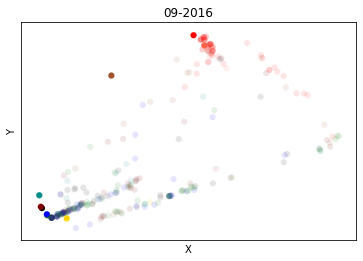

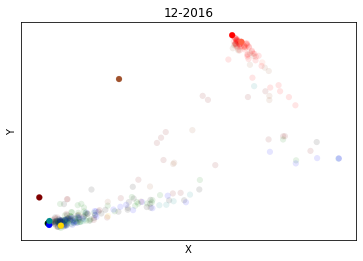

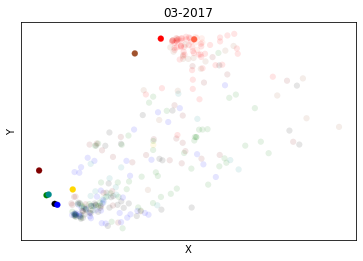

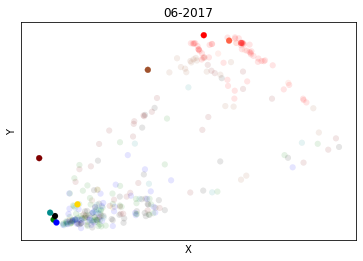

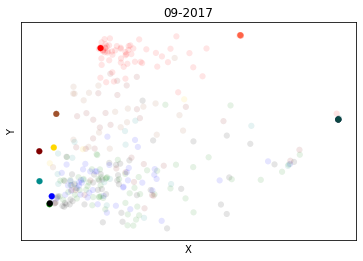

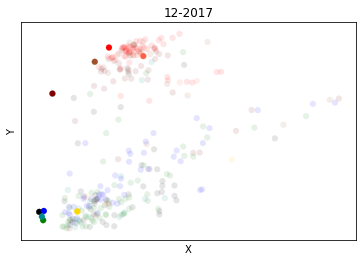

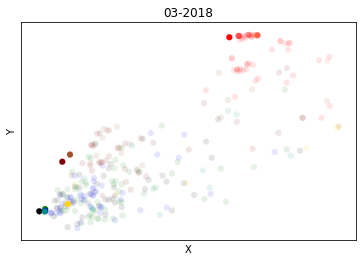

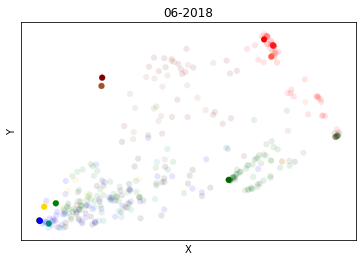

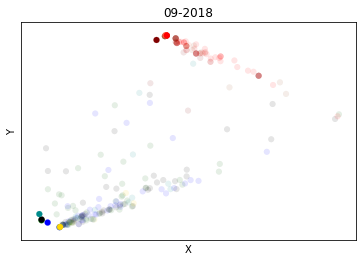

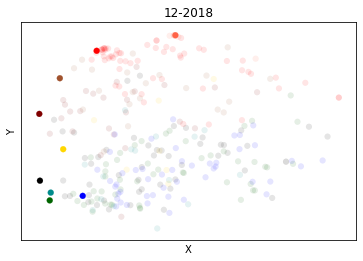

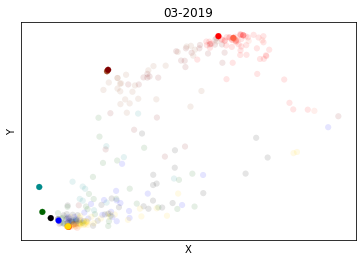

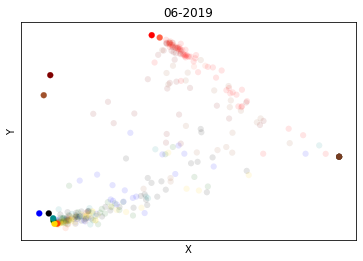

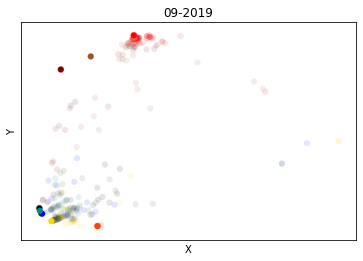

In [66]:
grouped_by = modelagem.groupby(pd.Grouper(freq='M') )
for i, (month_date, group) in tqdm_notebook(enumerate(grouped_by), total=len(grouped_by)):
    if group.shape[0] == 0:
        continue
    
    #group['x'] = (group['x']-group['x'].mean())/group['x'].std()
    #group['x'] = group['x']/max(abs(group['x']))
    
    #group['y'] = (group['y']-group['y'].mean())/group['y'].std()
    #group['y'] = group['y']/max(abs(group['y']))
    
    # plot deputados
    group_deputado = group[ [ t == 'deputado' for t in group['tipo']] ]
    group_deputado = group_deputado[ [p in colors_static for p in group_deputado['partido']] ]
    colors_to_use = [ get_color_static(p) for p in group_deputado['partido']  ]
    
    x = group_deputado['x']
    y = group_deputado['y']
    
    plt.scatter(x, y, linewidths=0.1, alpha=0.1, c=colors_to_use)#, main=month_date.strftime('%m-%Y'), xticks=[], yticks=[])
    
    plt.title(month_date.strftime('%m-%Y'))
    plt.xlabel('X')
    plt.xticks([])
    plt.ylabel('Y')
    plt.yticks([])
    
    # plot partidos
    group_partidos = group[ [ t == 'partido' for t in group['tipo']] ]
    group_partidos = group_partidos[ [p in colors_static for p in group_partidos['partido']] ]
    colors_to_use = [ get_color_static(p) for p in group_partidos['partido']  ]
    
    x = group_partidos['x']
    y = group_partidos['y']
    
    plt.scatter(x, y, linewidths=0.2, c=colors_to_use)#, main=month_date.strftime('%m-%Y'), xticks=[], yticks=[])
    
    plt.title(month_date.strftime('%m-%Y'))
    plt.xlabel('X')
    plt.xticks([])
    plt.ylabel('Y')
    plt.yticks([])
    
    
    plt.show()